# Planet assets download

In [1]:
#Python modules
import os
import time
import requests
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import geojson
import json
import shapely as sp
from shapely.geometry import shape
import pandas as pd
from shapely import wkb
from pprint import pprint
import rasterio 
from rasterio import plot
from descartes import PolygonPatch
from functools import partial
import pyproj
import re

#from osgeo import gdal 
#from osgeo import gdal_array


#Database modules - They are called already on the module
from sqlalchemy import *
from geoalchemy2 import *
from sqlalchemy import func
from sqlalchemy.orm import *

#Our modules
import utils
from utils import db_connect
from src.sat_imagery import gbdx_intersection as sat

%matplotlib inline

### SQL conn to get intersection database

In [2]:
engine_output = db_connect.alchemy_connect()
conn_output = engine_output.connect()
ts_overlap_planet = pd.read_sql_query("SELECT * FROM planet_metadata.overlap_torres_strait_planet",con=engine_output)
#ais_gbdx_overlap["time_diff"] = (abs(ais_gbdx_overlap.timestamp - ais_gbdx_overlap.timestamps)).astype('timedelta64[s]')

In [4]:
#Interactive plot with available imagery
import folium
import shapely.wkb
from shapely import ops

#Create an interactive Leaflet map with the location of the torres strait
torres_strait_planet = folium.Map(location = [26.060028, -33.924573], 
                           tiles='cartodbpositron', 
                           zoom_start=3)

#Tiles: Only plot the available images with the same color
tiles_geojson = []
for img in ts_overlap_planet['geom_wkt']:
    tiles_geojson.append(
        geojson.Feature(geometry=shapely.wkb.loads(img, hex=True), properties={})
    )
    
#Points: Only plot the available images with the same color
pts_list = []
for pts in ts_overlap_planet['geom']:
    pts_sp = shapely.wkb.loads(pts, hex=True)
    pts_list.append([[y, x] for x, y in pts_sp.coords][0])

    
for tile in tiles_geojson:
    folium.GeoJson(tile).add_to(torres_strait_planet)

    
for pts in pts_list:
    folium.CircleMarker(location = pts, radius=1,
                        color='#FE2E2E',
                        fill_color='#FE2E2E').add_to(torres_strait_planet)
    
    



In [5]:
torres_strait_planet

### Planet API Call and image retrival

In [6]:
#Set up objetcs to make download request (clipping images!)

# Set Scene ID list
scene_id = ts_overlap_planet['id'].tolist()

# Set Item Type list
item_type = ts_overlap_planet['item_type'].tolist()
asset_type = 'visual'

In [7]:
#Call API
from planet import api
client = api.ClientV1(os.getenv('PLANET_API_KEY'))

In [11]:
#Activate requests (tell Planet that be ready to start image downloading)
assets_list = []
for ids, item in zip(scene_id, item_type):
    assets_list.append(client.get_assets_by_id(id = ids, item_type=item).get())
    

In [12]:
#Activate the assets and get the status (204 is the good code ;])
activation_list = [client.activate(x['analytic']) for x in assets_list if 'analytics' in x.keys()]
for e, i in enumerate(activation_list):
    print(i.response.status_code)

In [20]:
#Download images! (mnt/data)
callback = api.write_to_file(directory="/mnt/data/shared/planet/imgs_ts")
body = []
for i in assets_list:  
    if "analytic" in i.keys():
        body.append(client.download(i['analytic'], callback=callback))

# Image processing

In [26]:
#Load requests
planet_torres_strait = []
with open('/mnt/data/shared/planet/results_planet_torres_strait.txt', 'r') as json_file:
    for line in json_file:
        planet_torres_strait.append(eval(line))

In [36]:
#Get images that were downloaded
files_planet = os.listdir("/mnt/data/shared/planet/imgs_ts/")
files_planet_dowloaded = [re.sub('_3B_AnalyticMS.tif', "", i) for i in files_planet]
download_scenes = [x for x in set(scene_id) if x in files_planet_dowloaded]

35

In [48]:
#Subset planet dataframe
planet_sub = ts_overlap_planet[ts_overlap_planet['id'].isin(download_scenes)]

#Define buffers
buffers_selected_mmsi = [geojson.dumps(sat.wkt_to_json(sat.create_buffers_points(x, 600, proj=False))) 
                          for x in planet_sub['geom']]

In [49]:
def scale8bit(image):
    scale = float(256) / (image.max() - image.min())
    return np.clip(np.round(np.multiply(image, scale)), 0, 255).astype(np.uint8)

geoms_sp = [shape(geojson.loads(x)) for x in buffers_selected_mmsi]

for img, geom in zip(planet_sub['id'], geoms_sp):
    #Open raster
    src = rasterio.open('/mnt/data/shared/planet/imgs_ts/' + img + '_3B_AnalyticMS.tif')
    #print(src.crs['init'])
    #print(src.bounds)
    
    #Get raster bounding box
    bounds = src.bounds
    bbox = [(bounds[0], bounds[3]), (bounds[2], bounds[3]), (bounds[2], bounds[1]), (bounds[0], bounds[1])]
    bbox_sp = sp.geometry.Polygon(bbox)
    
    #Project
    project_to_utz = partial(pyproj.transform,
                             pyproj.Proj(init='epsg:4326'),
                             pyproj.Proj(init=src.crs['init']))
    geom_proj = sp.ops.transform(project_to_utz, geom)
    #print(geom_proj.centroid.coords.xy)
    print(geom_proj.within(bbox_sp))



True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [50]:
from rasterio.warp import calculate_default_transform, reproject, Resampling
dst_crs = 'EPSG:4326'

#Resampling rasters

for img in planet_sub['id']:
    with rasterio.open('/mnt/data/shared/planet/imgs_ts/' +  img + '_3B_AnalyticMS.tif') as src:
        affine, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': affine,
            'affine': affine,
            'width': width,
            'height': height
        })
        
        with rasterio.open('/mnt/data/shared/planet/imgs_ts/'+ 'proj_' + img + '_3B_AnalyticMS.tif', 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=affine,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [15]:
files_planet = os.listdir('/mnt/data/shared/planet/imgs_ts/')
files_planet_proj = [x for x in files_planet if x.startswith('proj_')]
files_planet_proj

['proj_20170527_235623_1041_3B_AnalyticMS.tif',
 'proj_20170602_235540_103b_3B_AnalyticMS.tif',
 'proj_20170527_235619_1041_3B_AnalyticMS.tif',
 'proj_20170527_235606_1031_3B_AnalyticMS.tif',
 'proj_20170619_235627_1019_3B_AnalyticMS.tif',
 'proj_20170523_000012_1019_3B_AnalyticMS.tif',
 'proj_20170522_235923_1012_3B_AnalyticMS.tif',
 'proj_20170517_235333_100e_3B_AnalyticMS.tif',
 'proj_20170522_235948_1019_3B_AnalyticMS.tif',
 'proj_20170429_065936_0c0b_3B_AnalyticMS.tif',
 'proj_20170619_235920_1031_3B_AnalyticMS.tif',
 'proj_20170504_235944_1017_3B_AnalyticMS.tif',
 'proj_20170616_235731_0f28_3B_AnalyticMS.tif',
 'proj_20170616_235701_103d_3B_AnalyticMS.tif',
 'proj_20170504_235945_1017_3B_AnalyticMS.tif',
 'proj_20170607_235623_0f41_3B_AnalyticMS.tif',
 'proj_20170607_235709_0f15_3B_AnalyticMS.tif',
 'proj_20161128_061547_1_0c41_3B_AnalyticMS.tif',
 'proj_20160703_064555_0c46_3B_AnalyticMS.tif',
 'proj_20161101_062106_0c42_3B_AnalyticMS.tif',
 'proj_20170623_000026_1025_3B_Analyti

In [54]:
from rasterio import mask as mask
path = '/mnt/data/shared/planet/imgs_ts/' 

for img, geom in zip(planet_sub['id'], buffers_selected_mmsi):
    with rasterio.open(path + 'proj_' + img + '_3B_AnalyticMS.tif') as src:
        out_image, out_transform = mask.mask(src, [geojson.loads(geom)], crop=True)
        out_meta = src.meta.copy()
        
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
        
        with rasterio.open(path + "crop_" + img + '.tif', "w", **out_meta) as dest:
            dest.write(out_image)
    


In [ ]:
path = '/mnt/data/shared/planet/imgs_ts/' 
files_planet_proj = [x for x in os.listdir(path) if x.startswith('proj_')]
geoms_sp = [shape(geojson.loads(x)) for x in buffers_selected_mmsi]

for img, geom in zip(planet_sub['id'], geoms_sp):
    #Open raster
    src = rasterio.open(path + 'proj_' + img + '_3B_AnalyticMS.tif')
    #print(src.crs['init'])
    #print(src.bounds)
    
    #Get raster bounding box
    bounds = src.bounds
    bbox = [(bounds[0], bounds[3]), (bounds[2], bounds[3]), (bounds[2], bounds[1]), (bounds[0], bounds[1])]
    bbox_sp = sp.geometry.Polygon(bbox)
    
    #Project
    project_to_utz = partial(pyproj.transform,
                             pyproj.Proj(init='epsg:4326'),
                             pyproj.Proj(init=src.crs['init']))
    geom_proj = sp.ops.transform(project_to_utz, geom)
    #print(geom_proj.centroid.coords.xy)
    print(geom_proj.within(bbox_sp))




0
crop_20170607_235623_0f41.tif


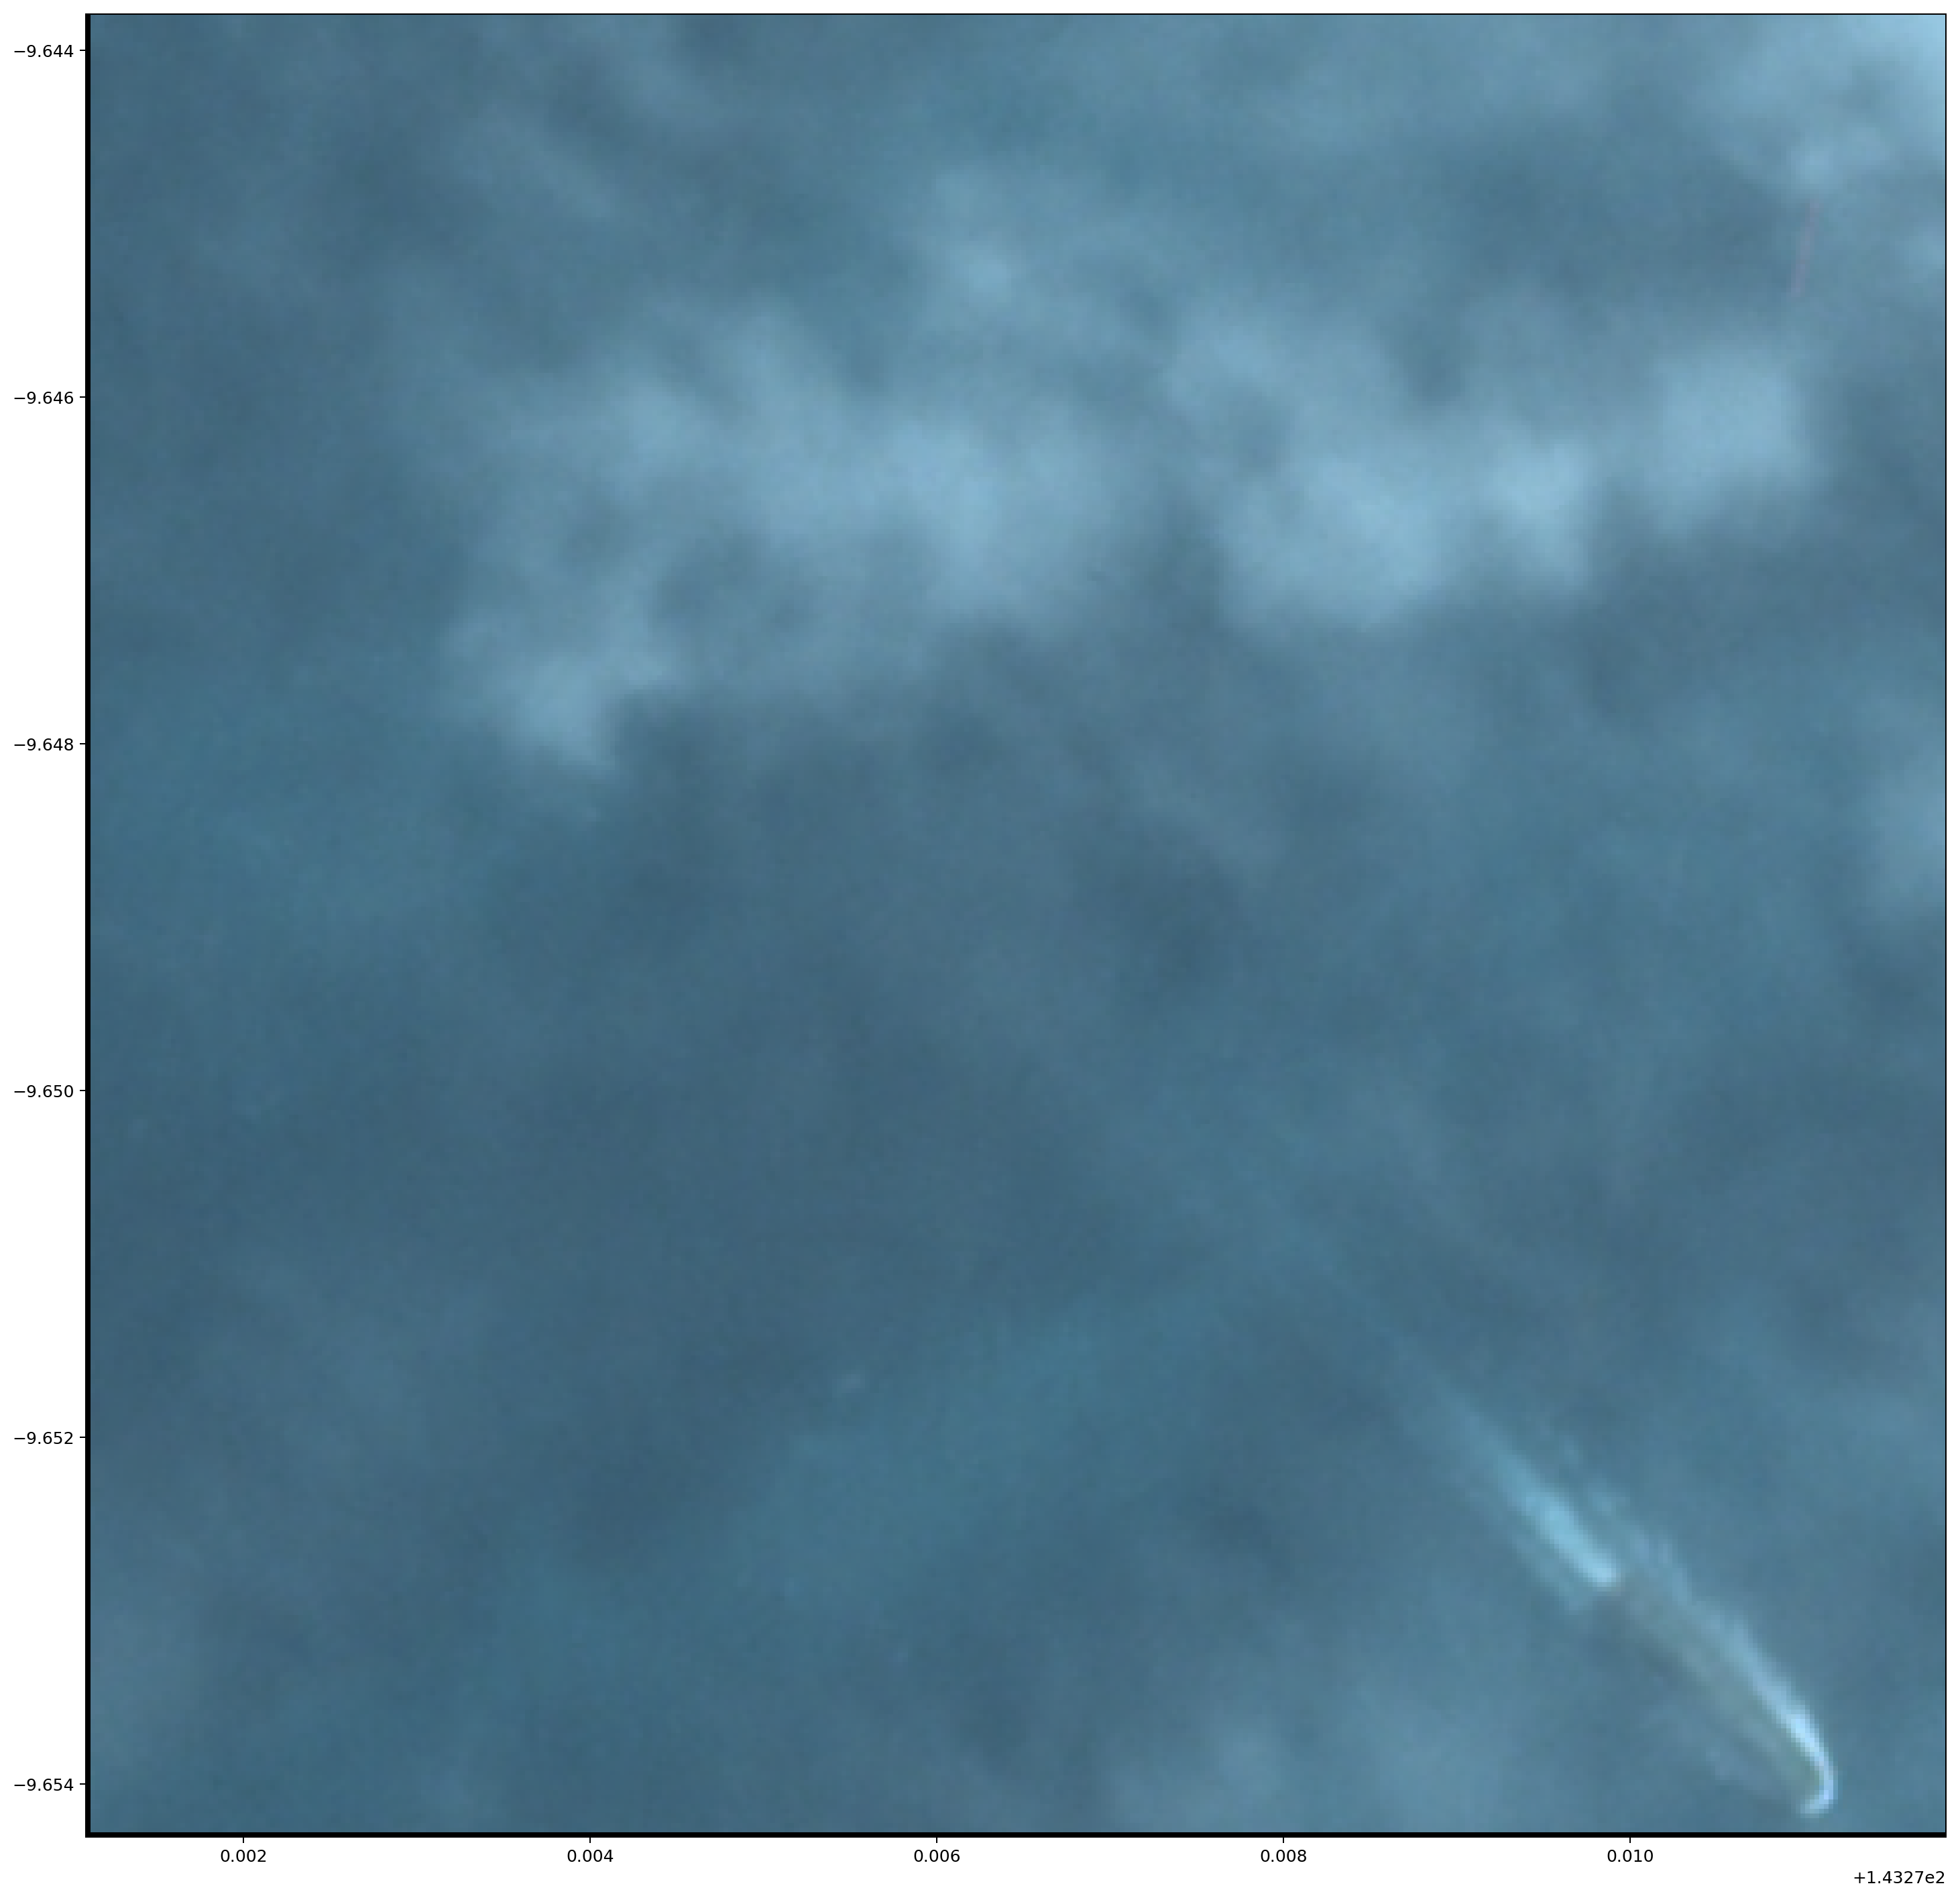

1
crop_20170619_235920_1031.tif


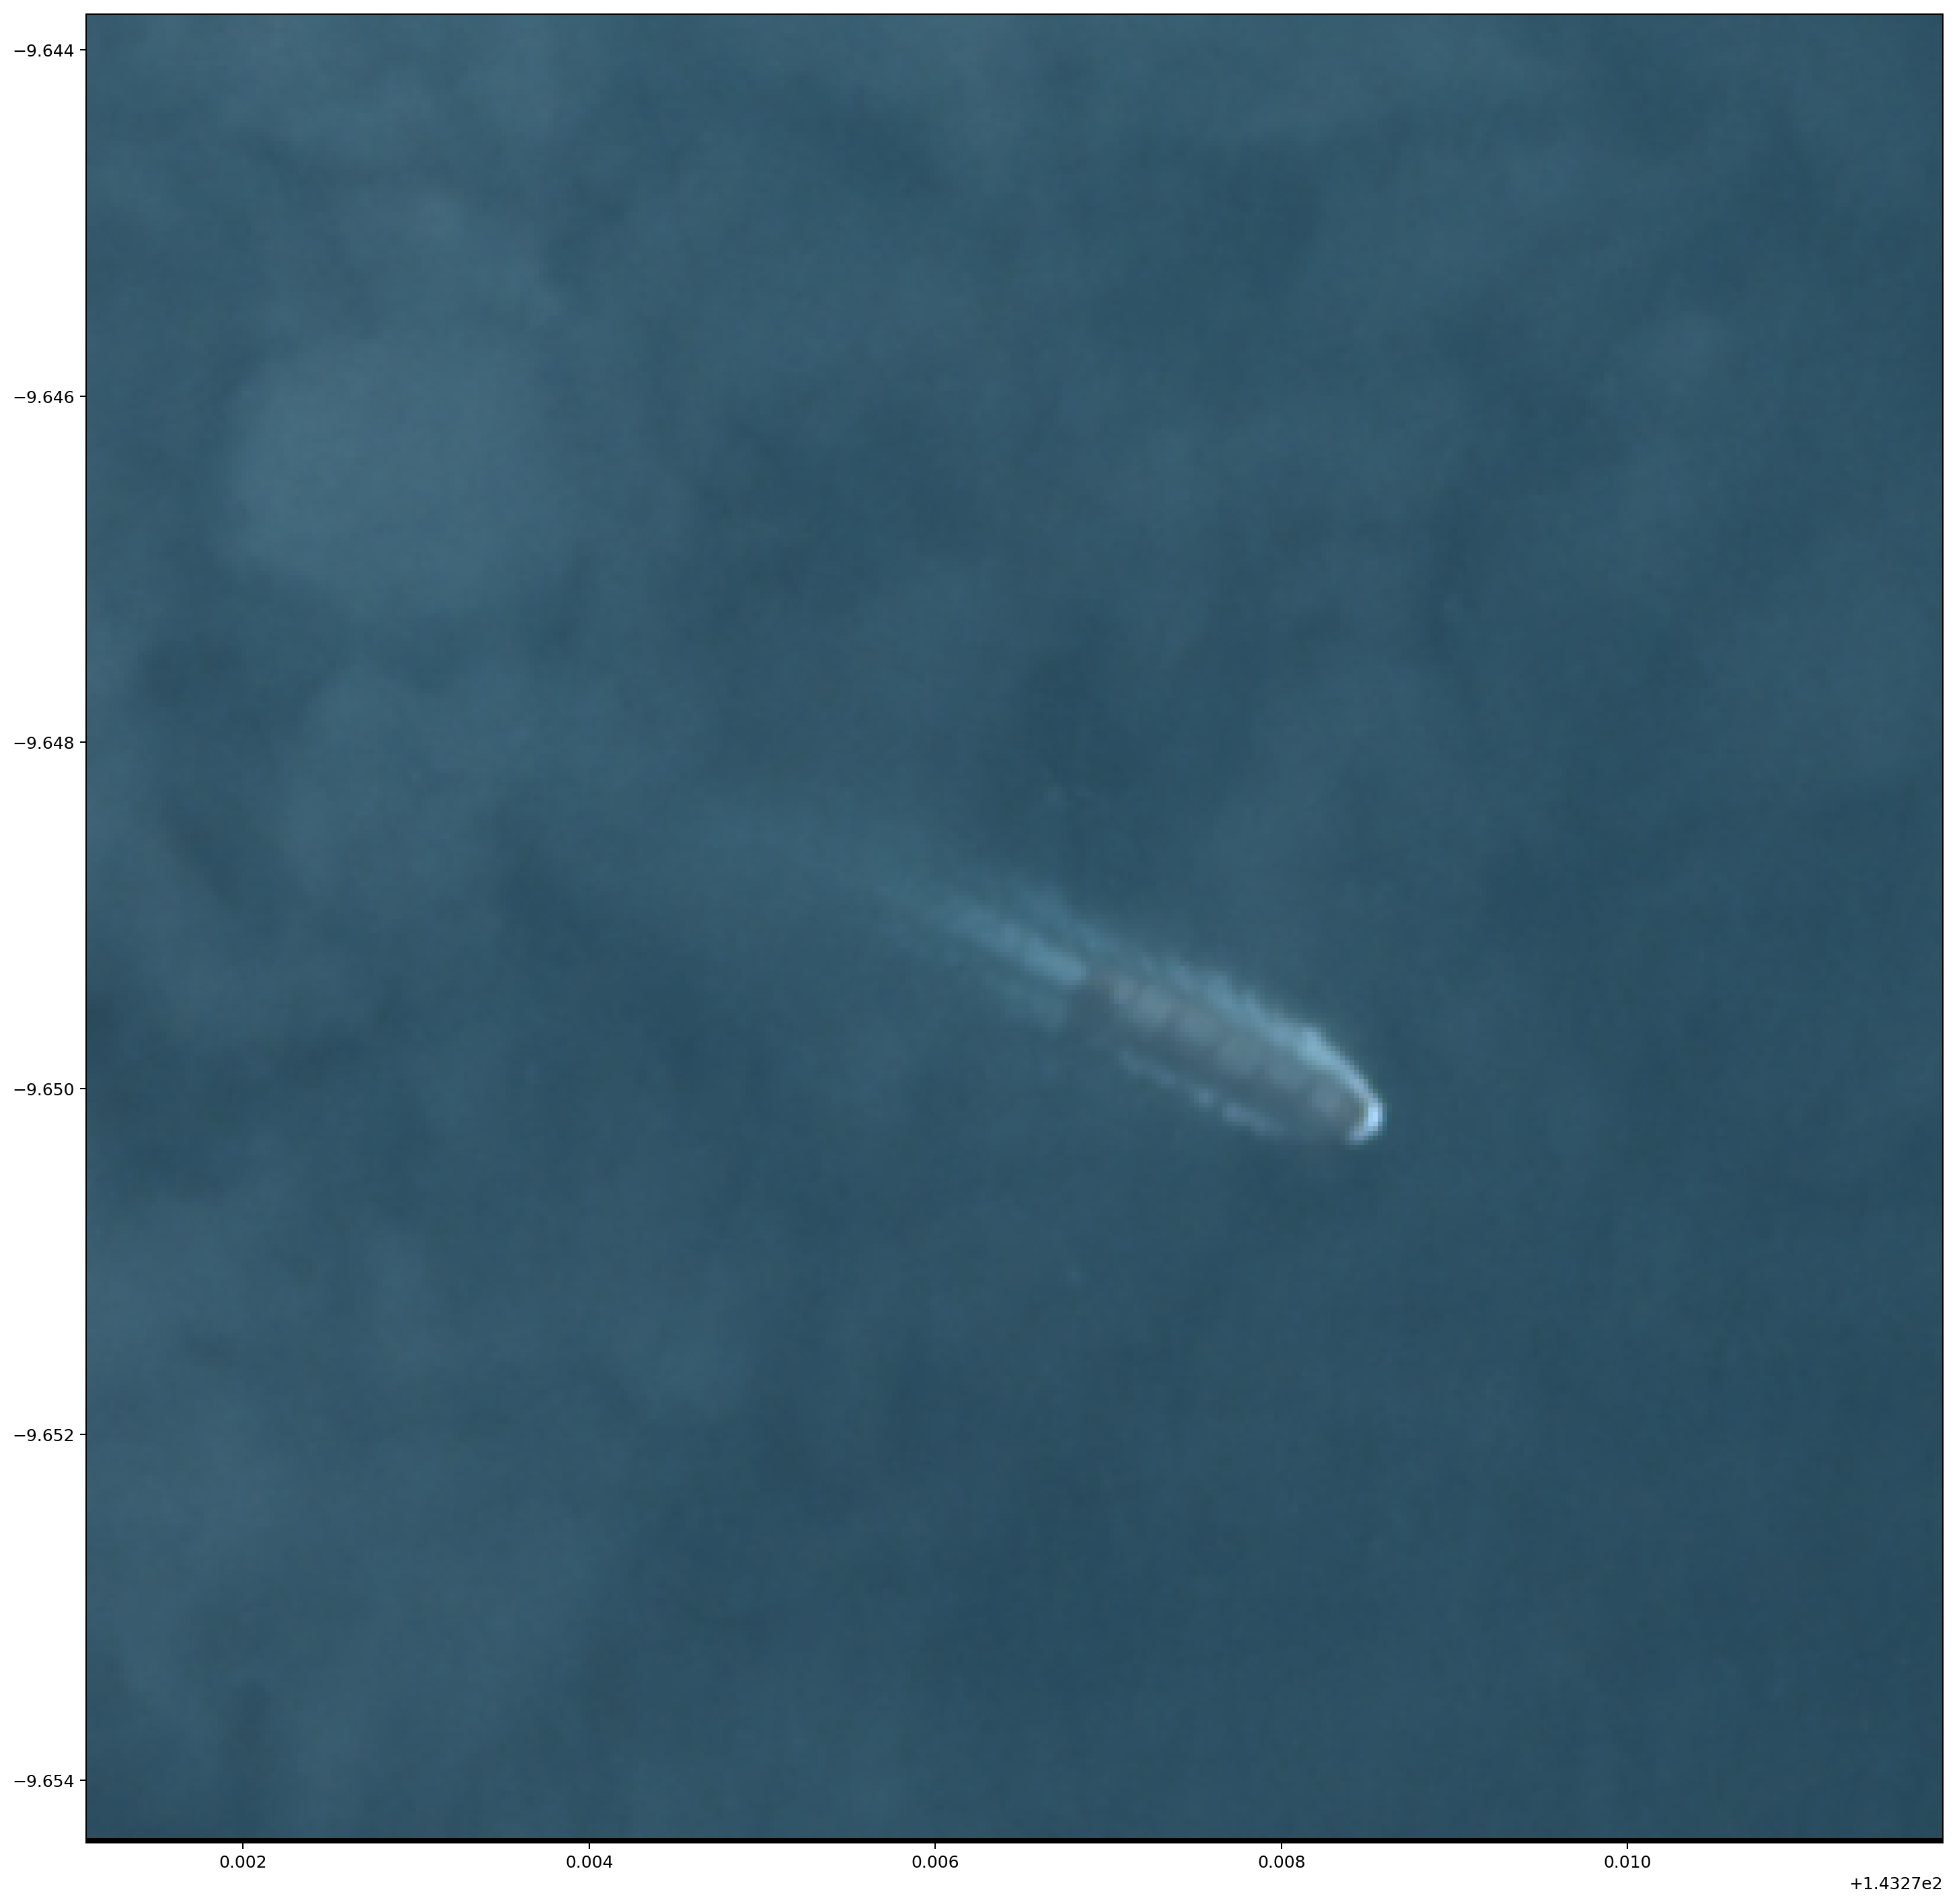

2
crop_20170607_235709_0f15.tif


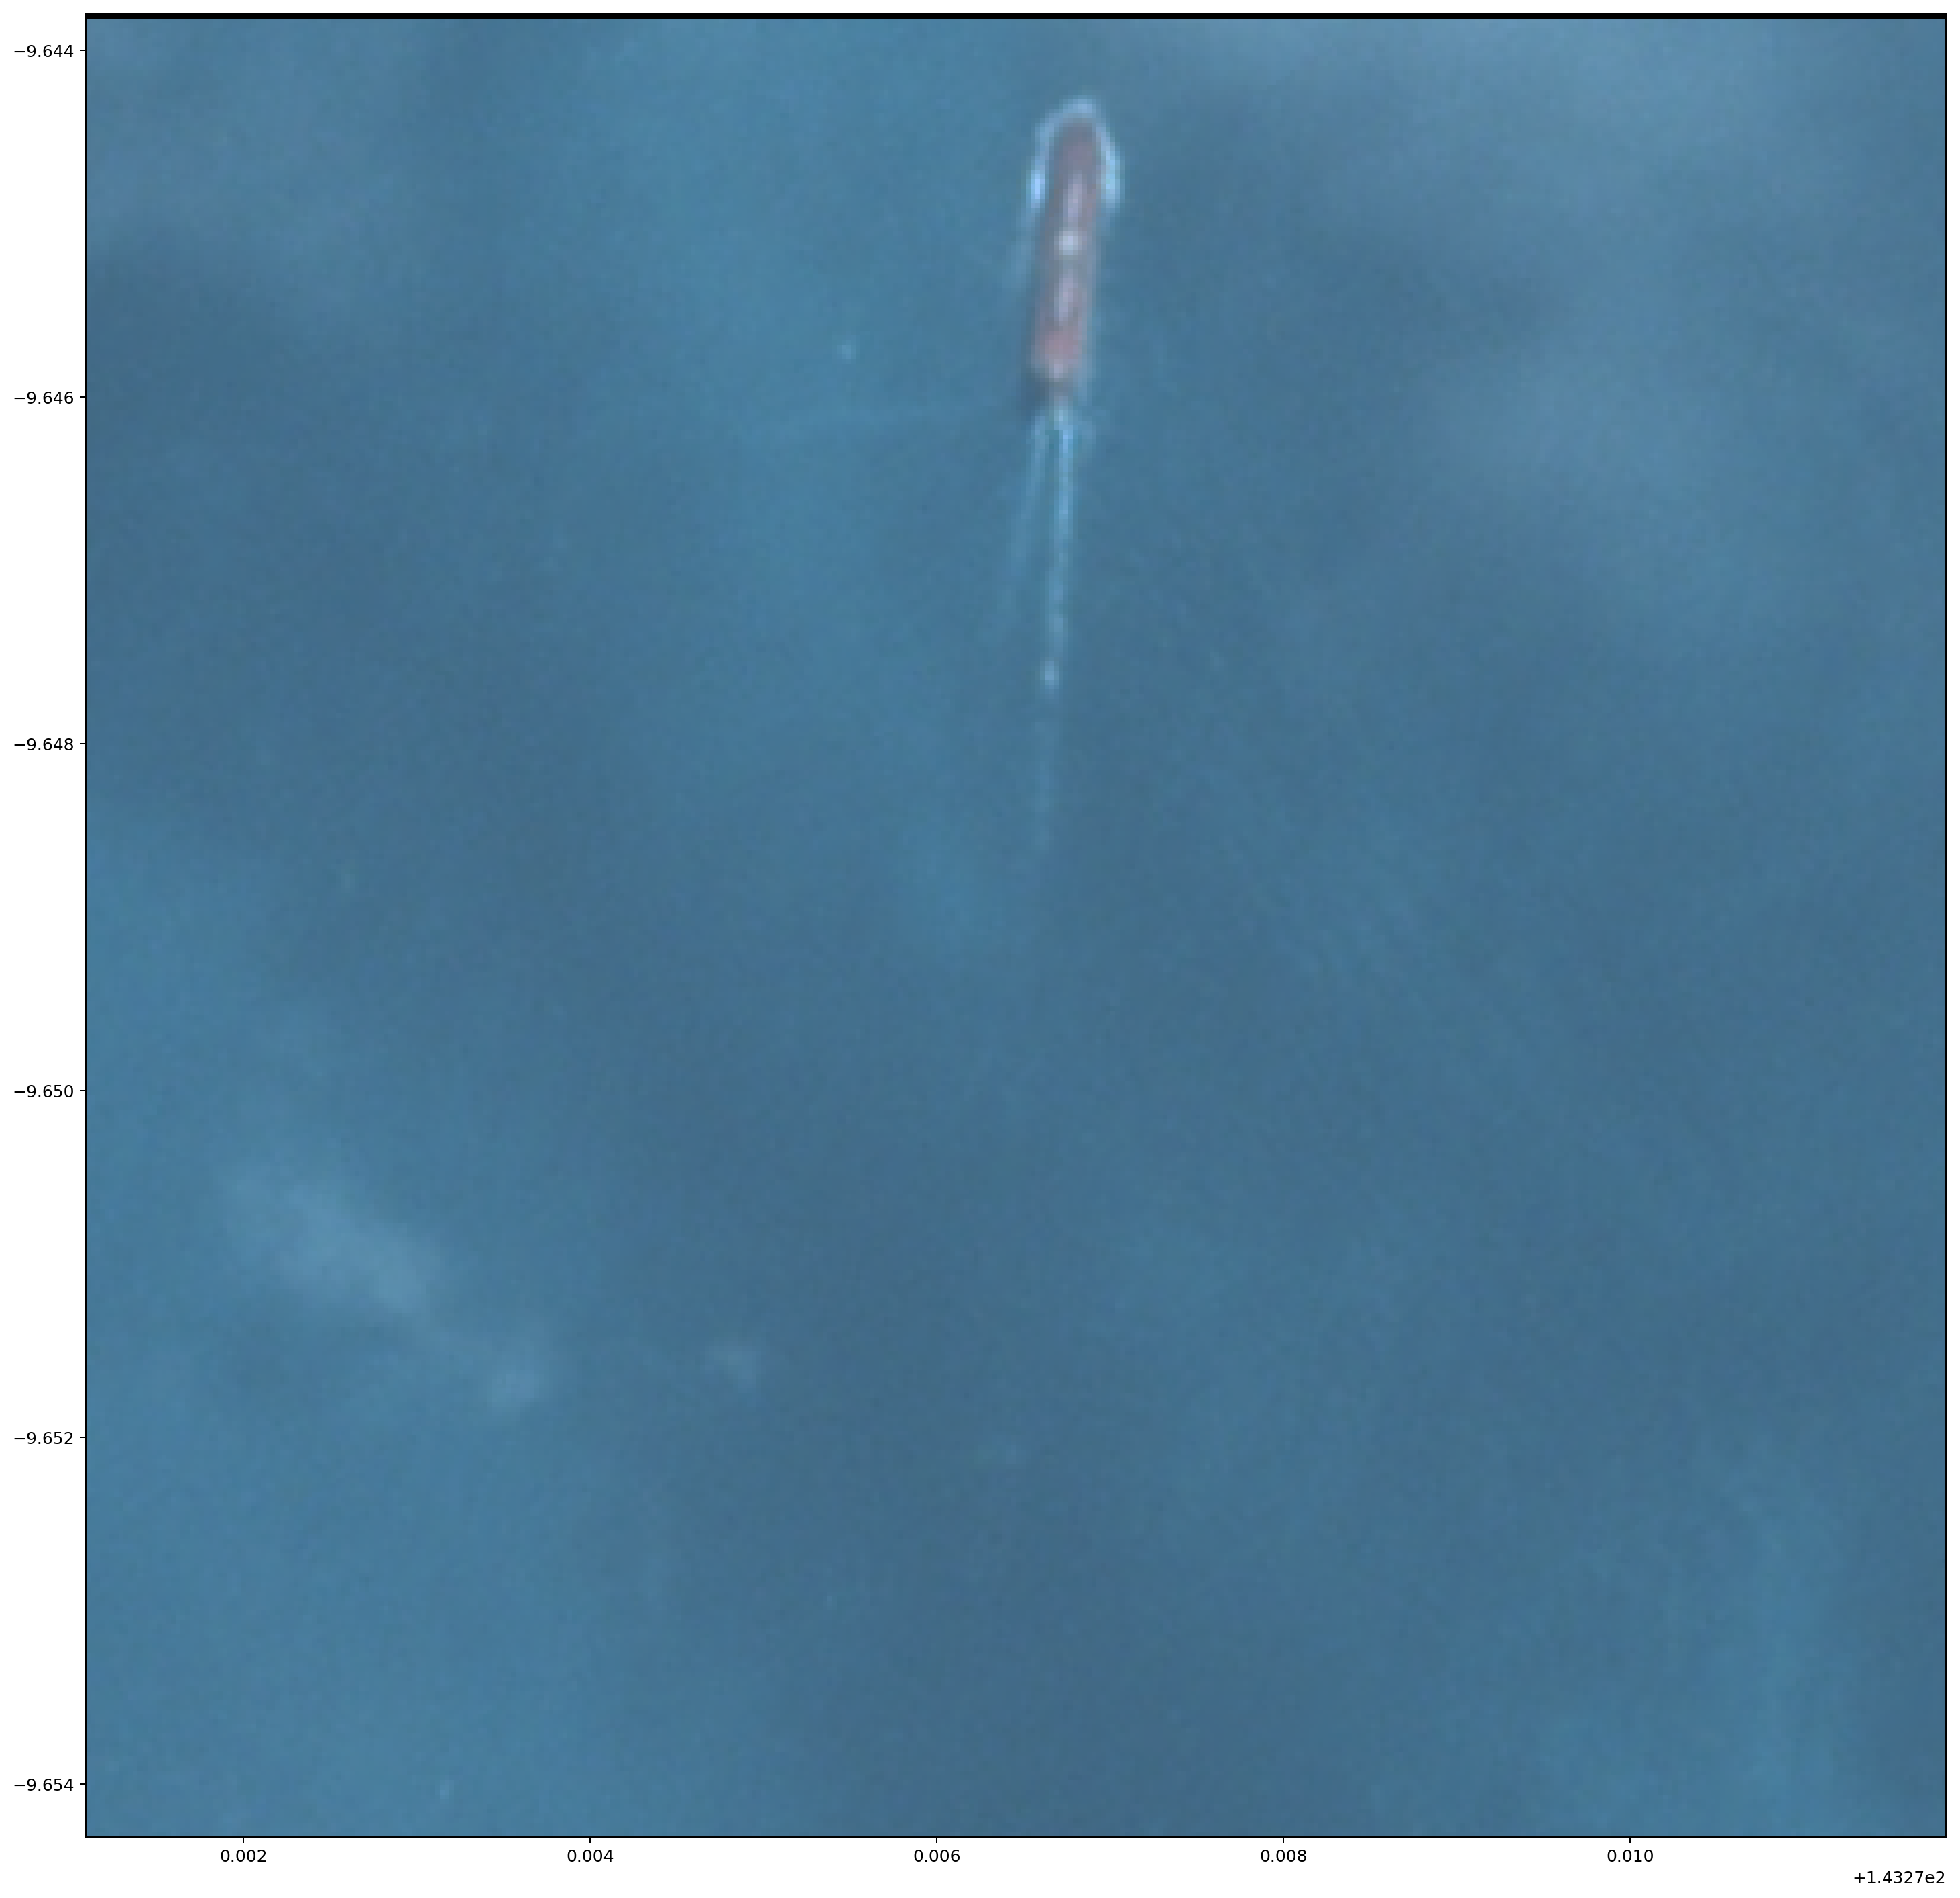

3
crop_20170527_235623_1041.tif


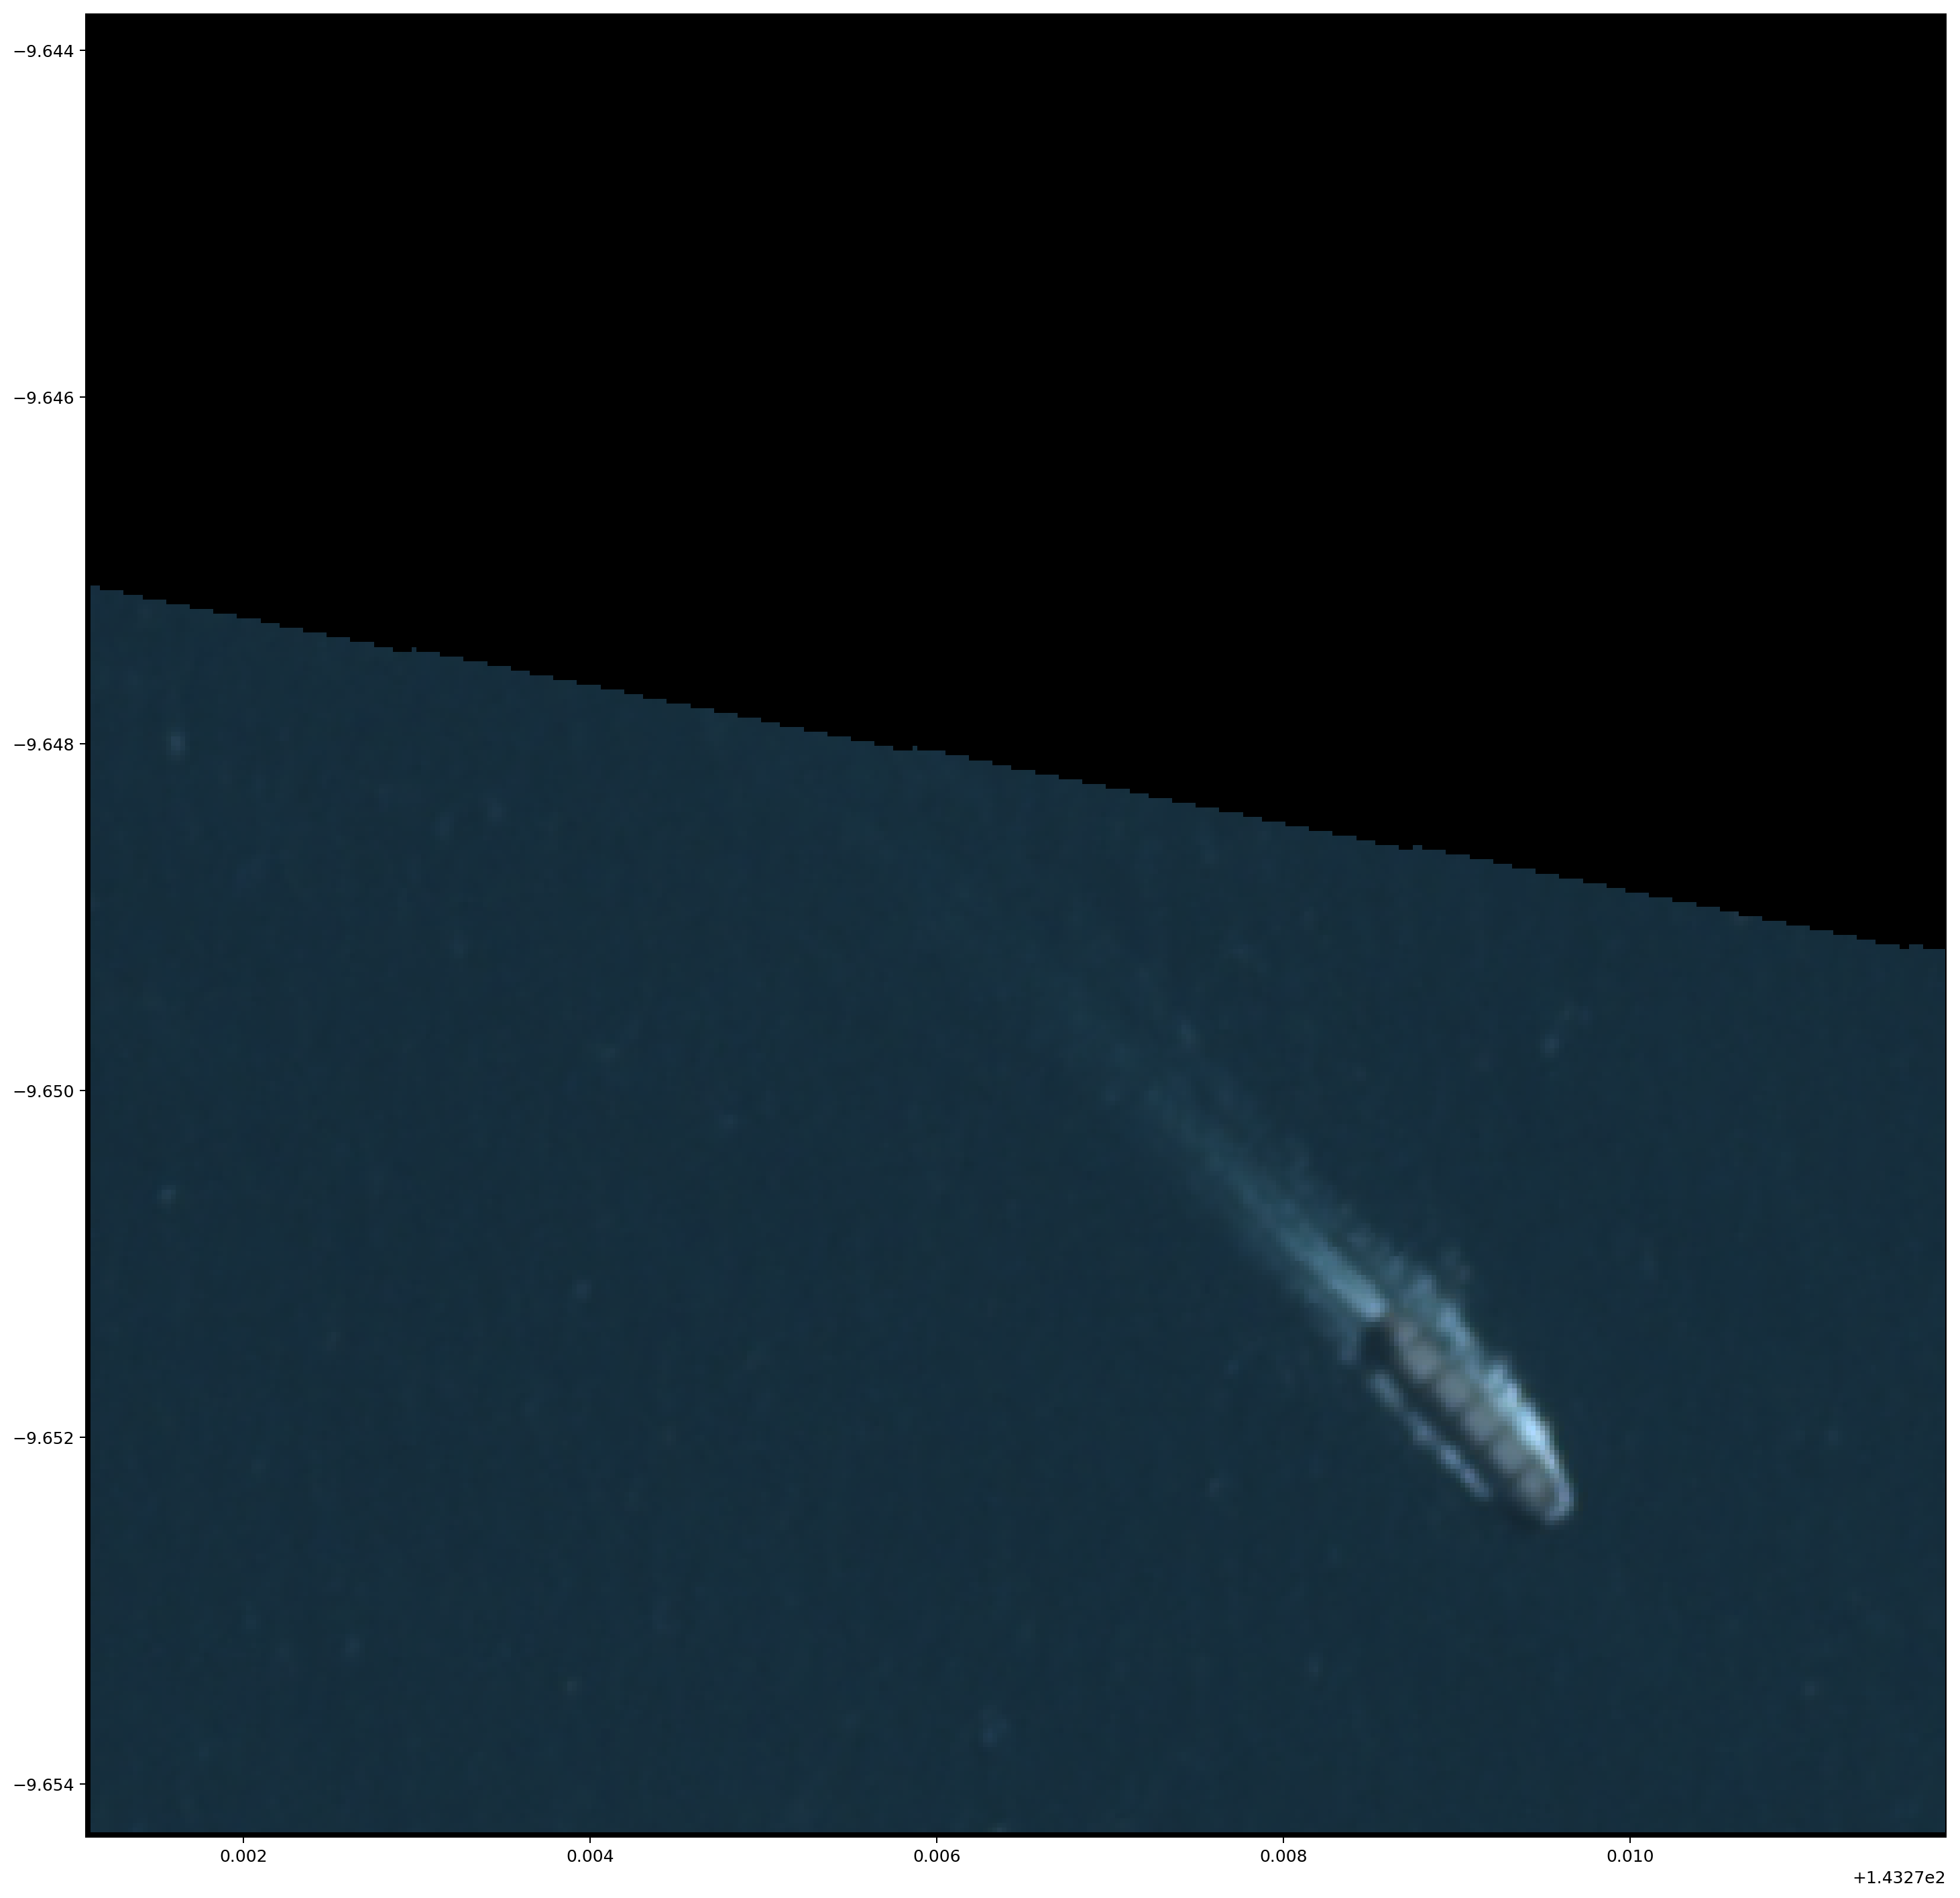

4
crop_20170527_235619_1041.tif


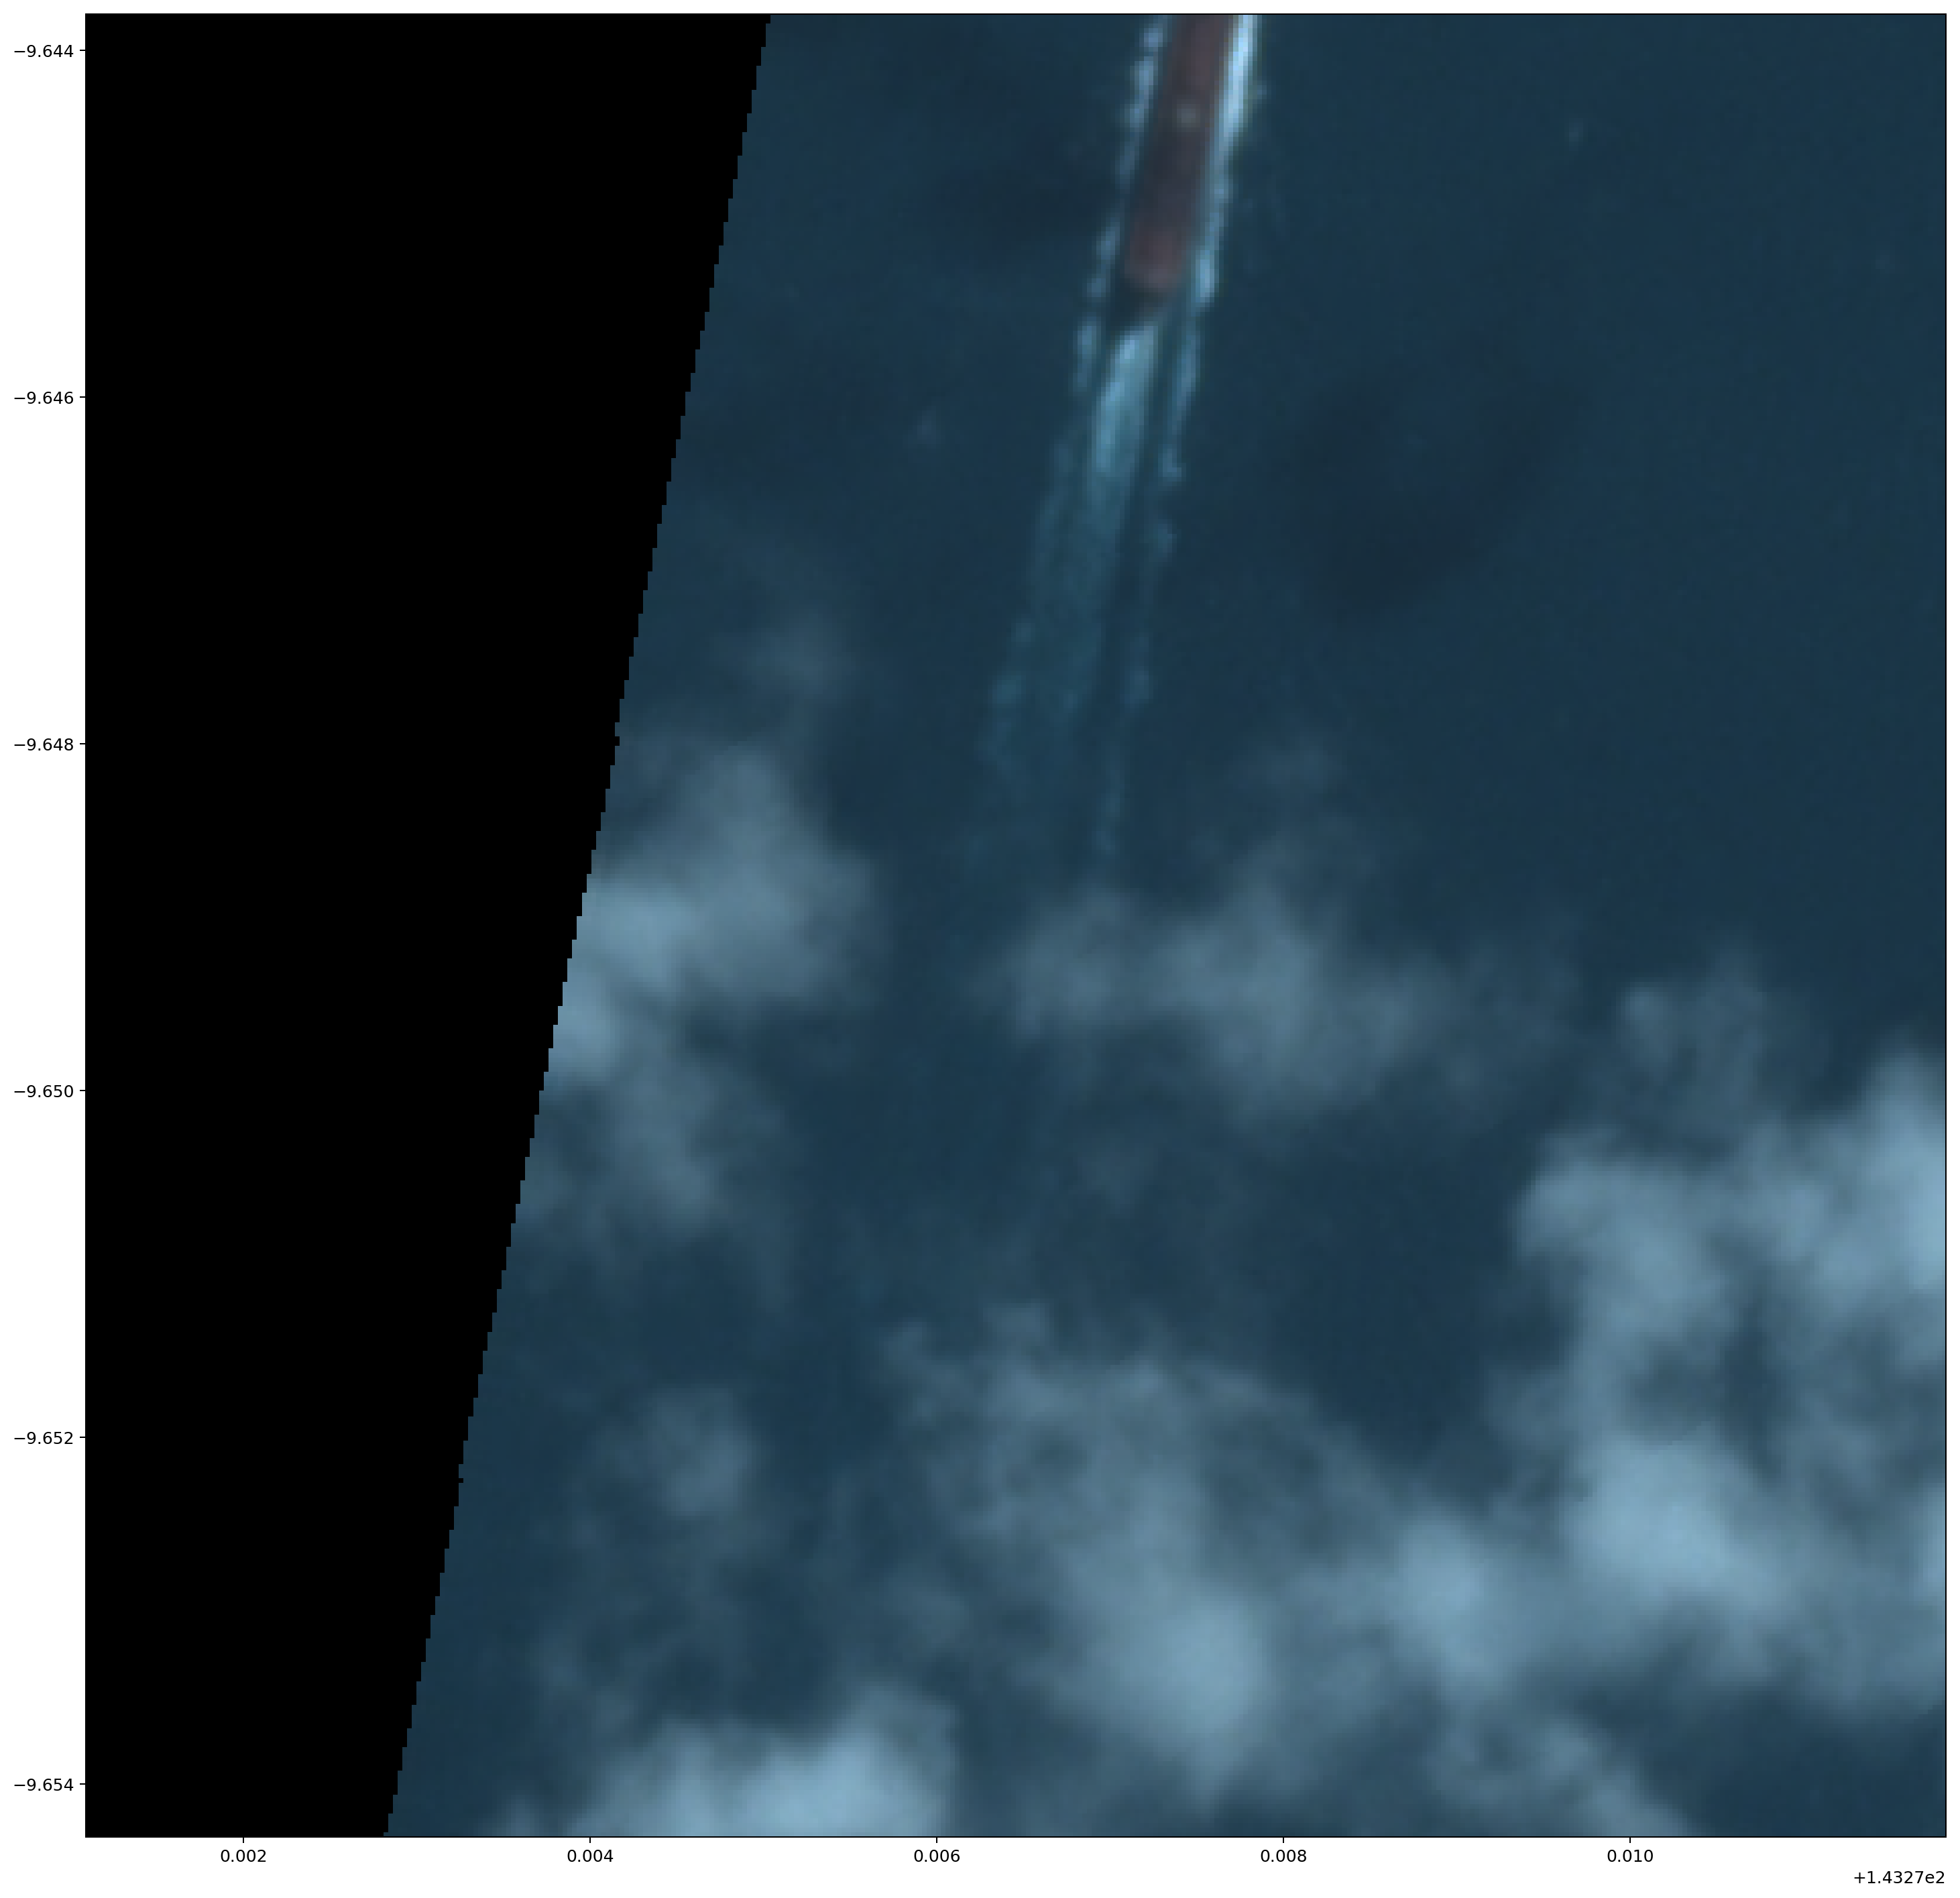

5
crop_20170527_235606_1031.tif


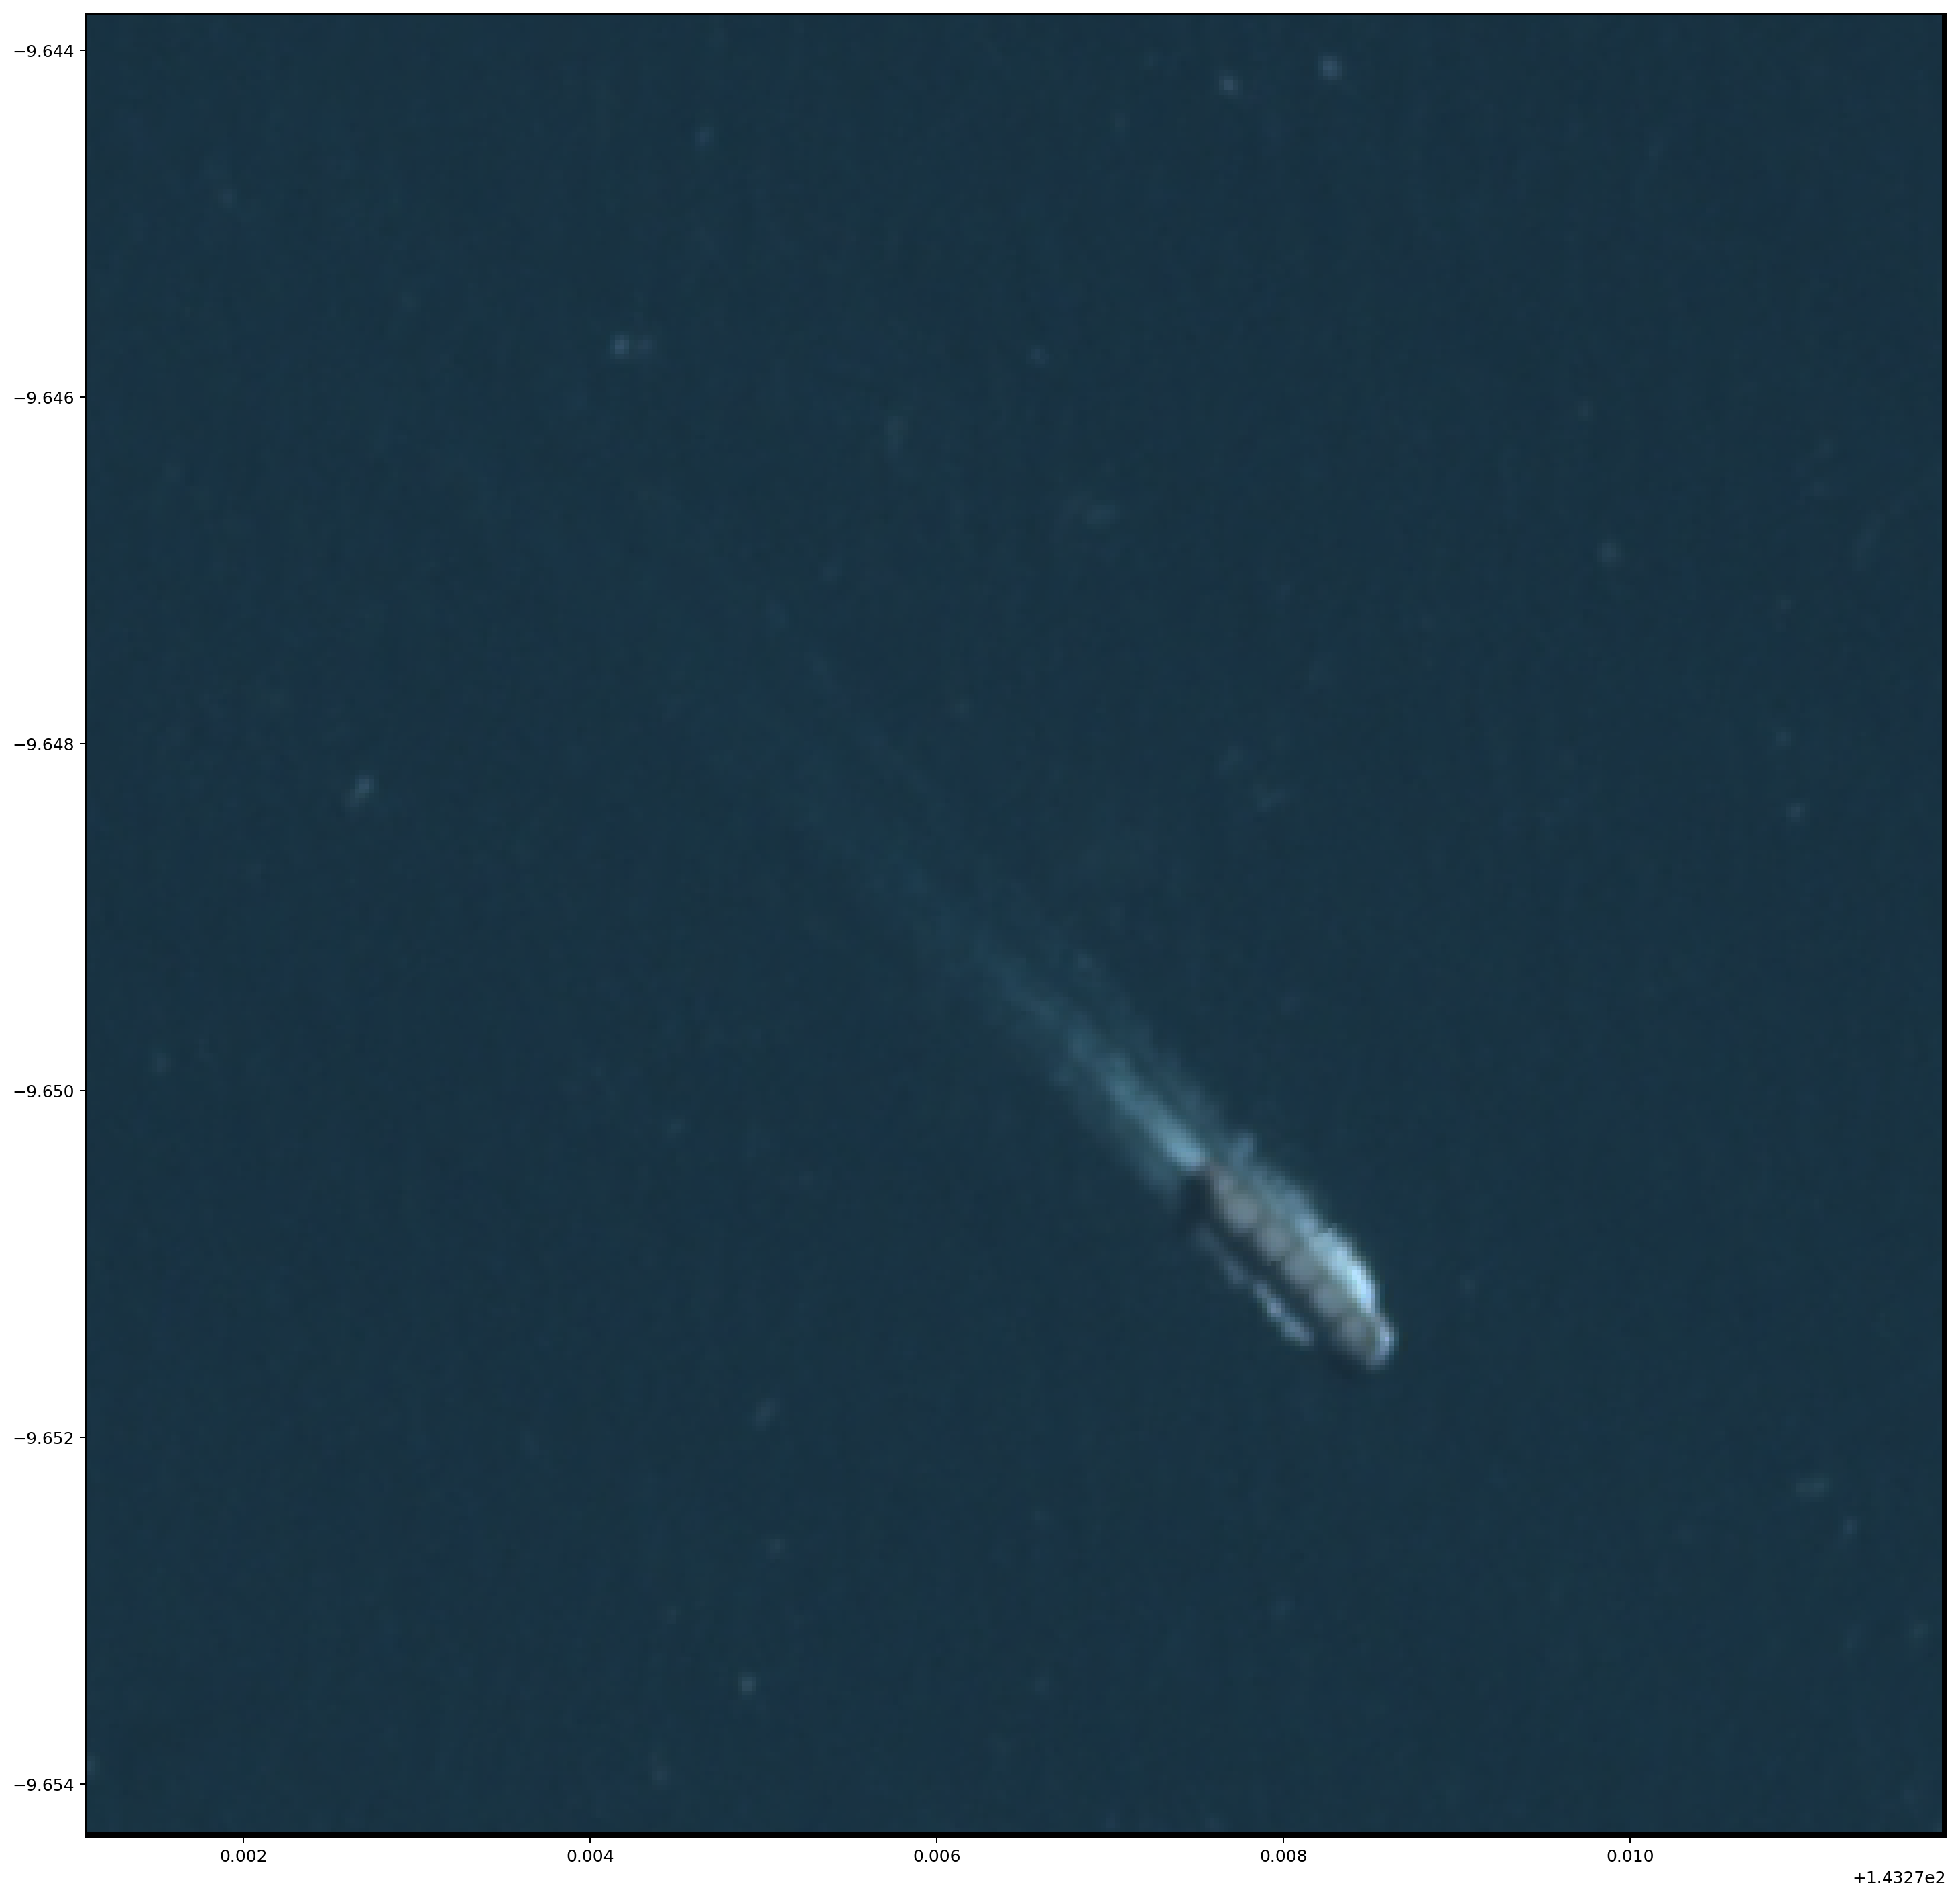

6
crop_20170522_235923_1012.tif


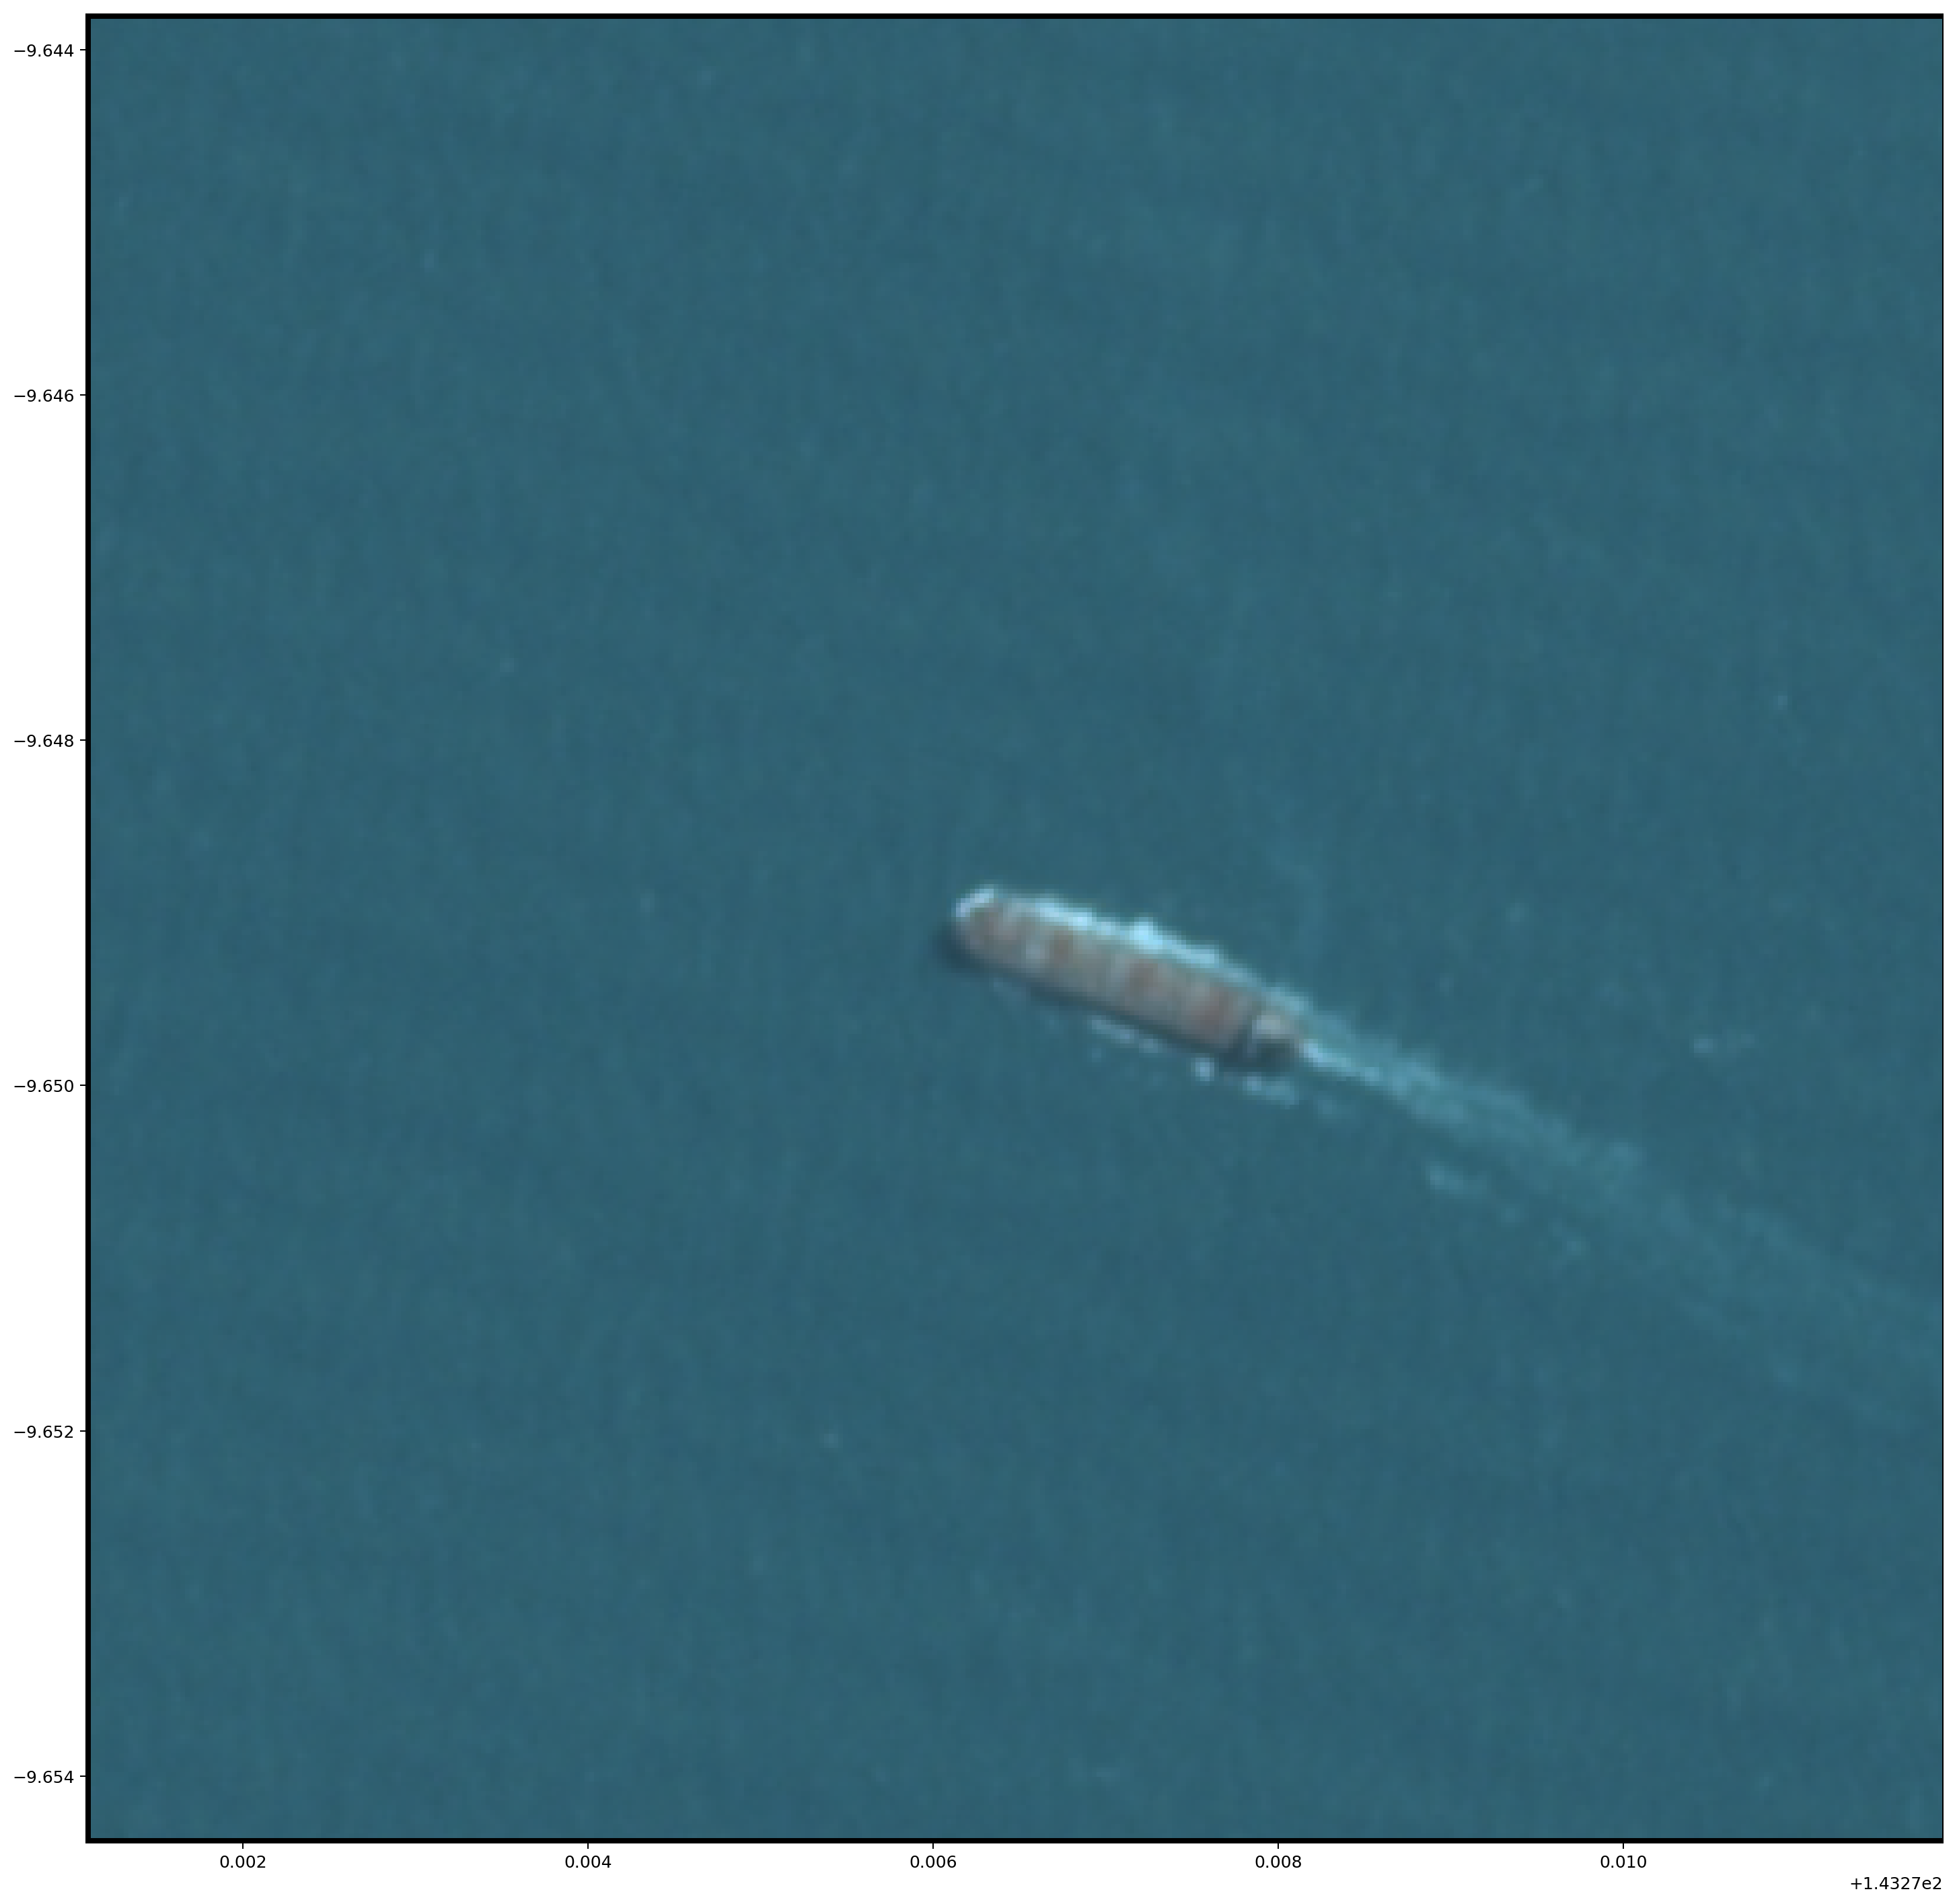

7
crop_20170522_235948_1019.tif


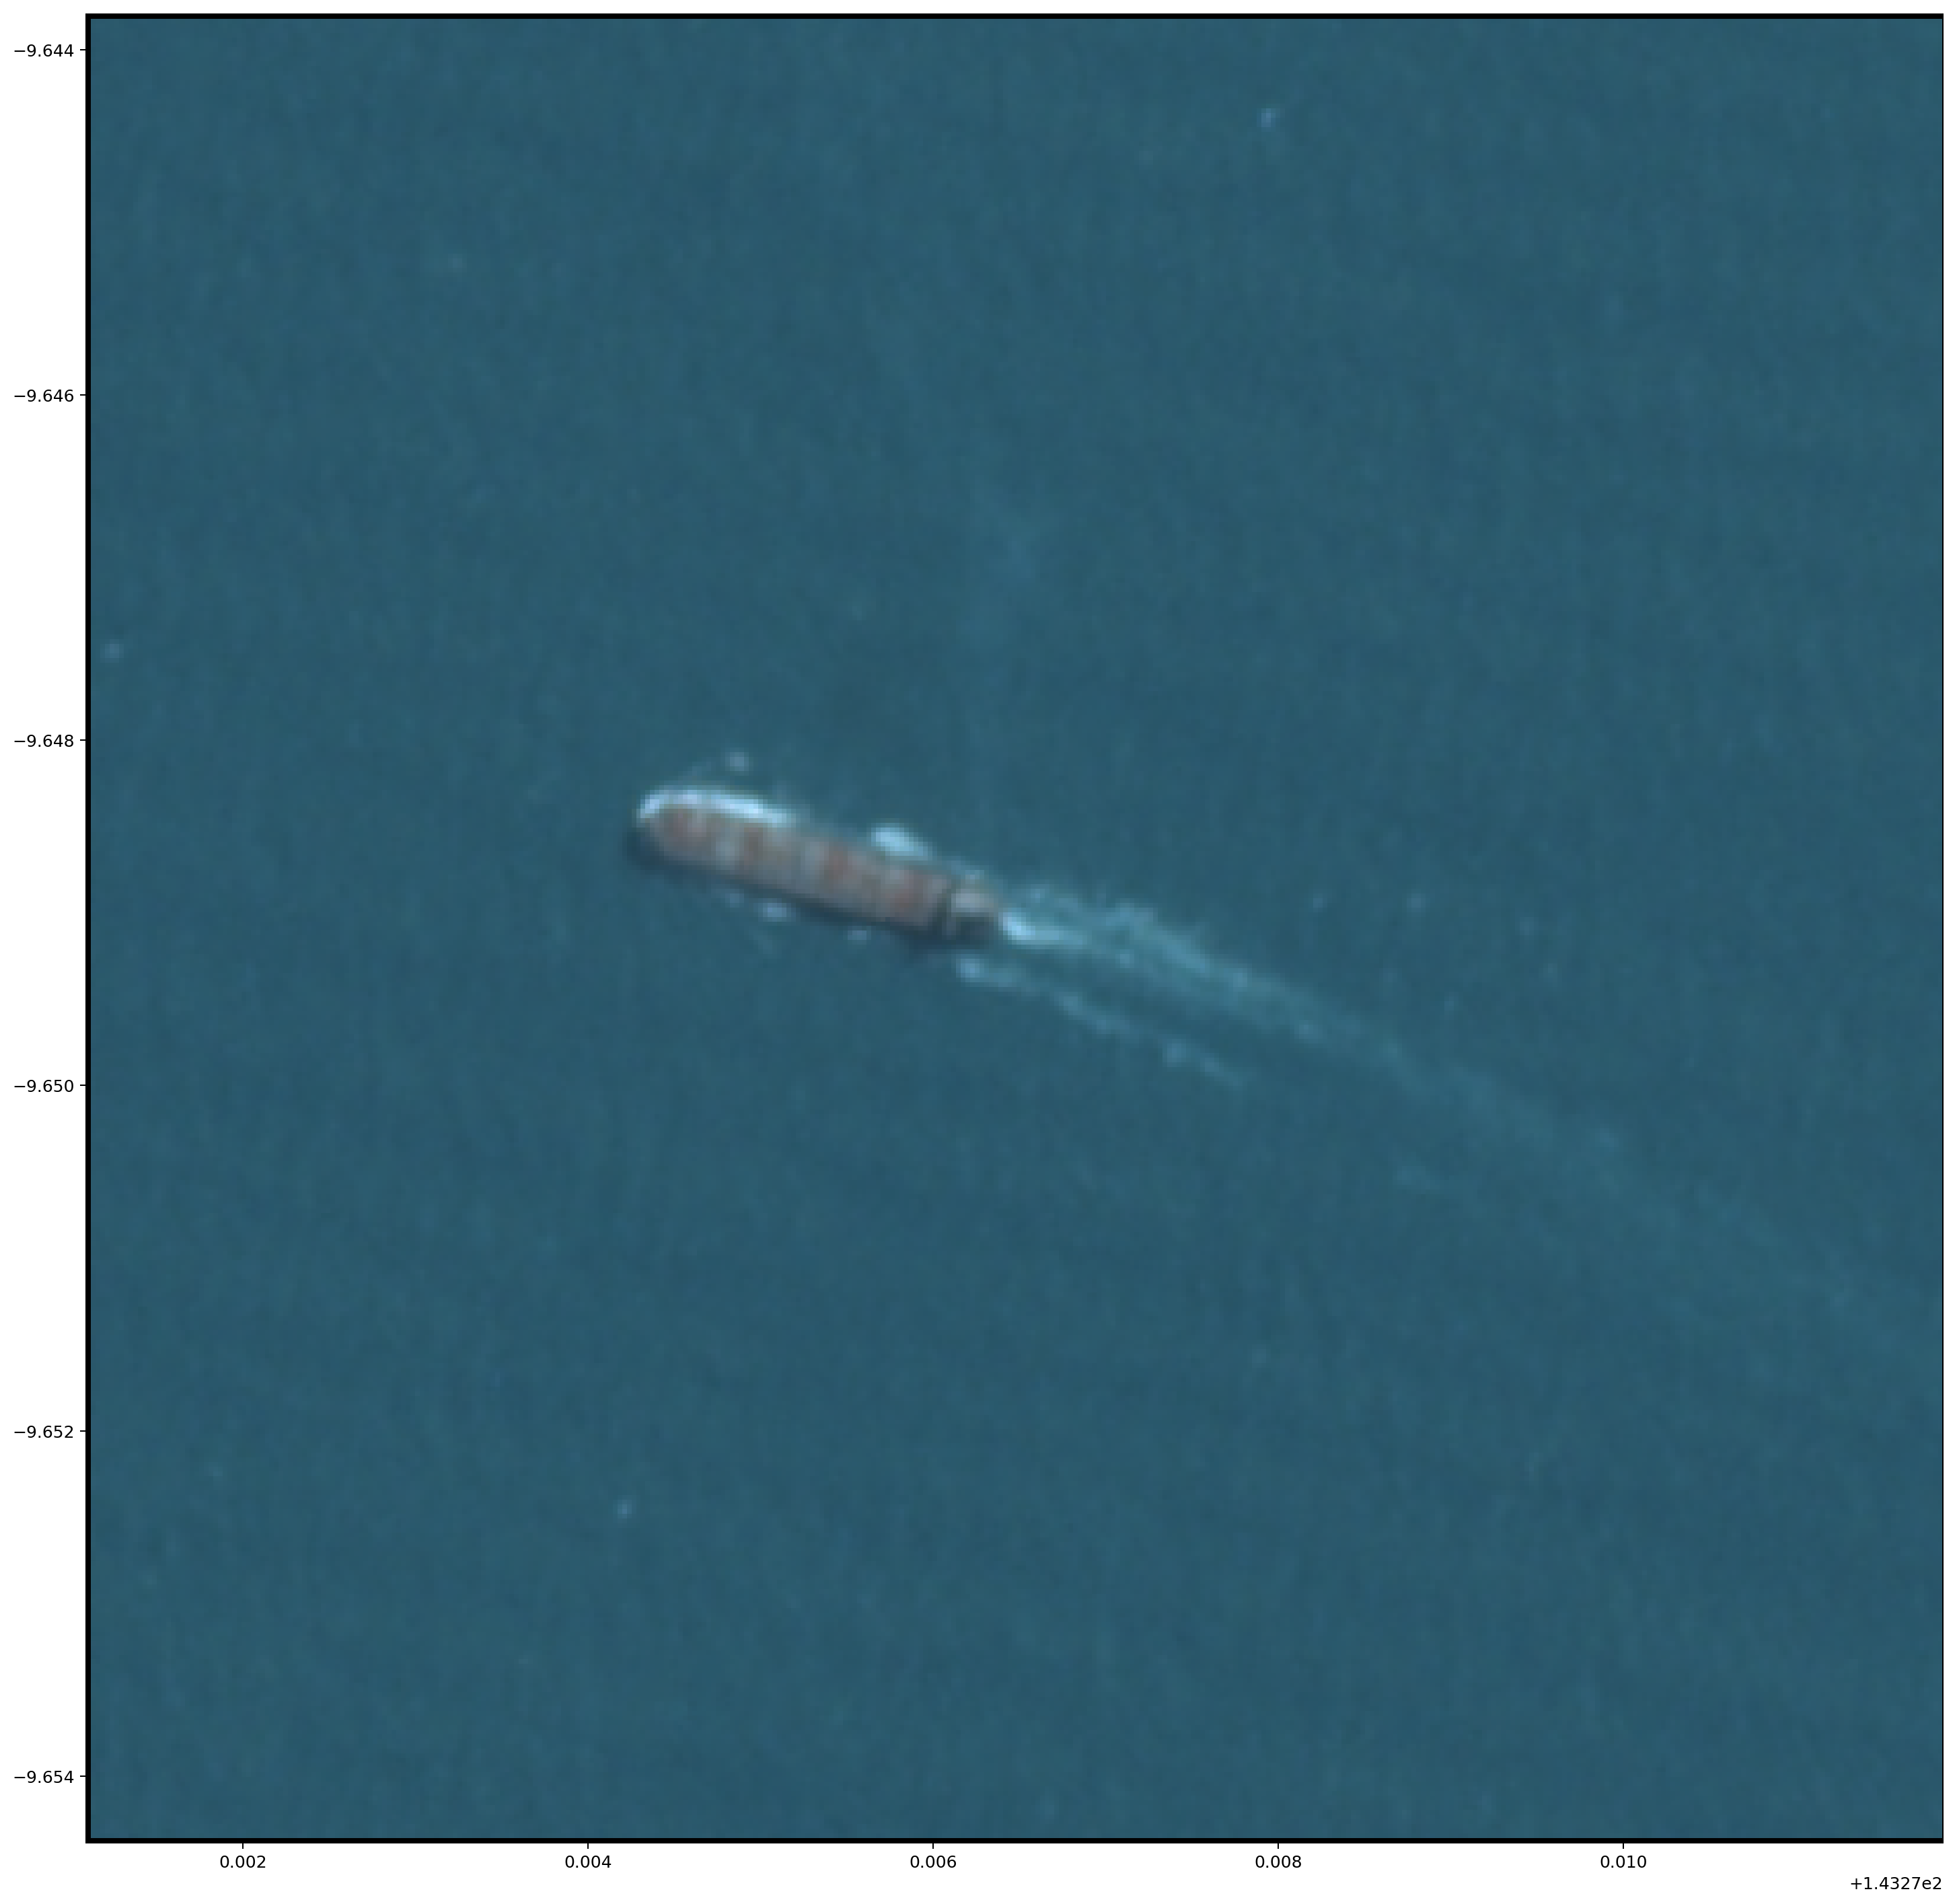

8
crop_20170504_235945_1017.tif


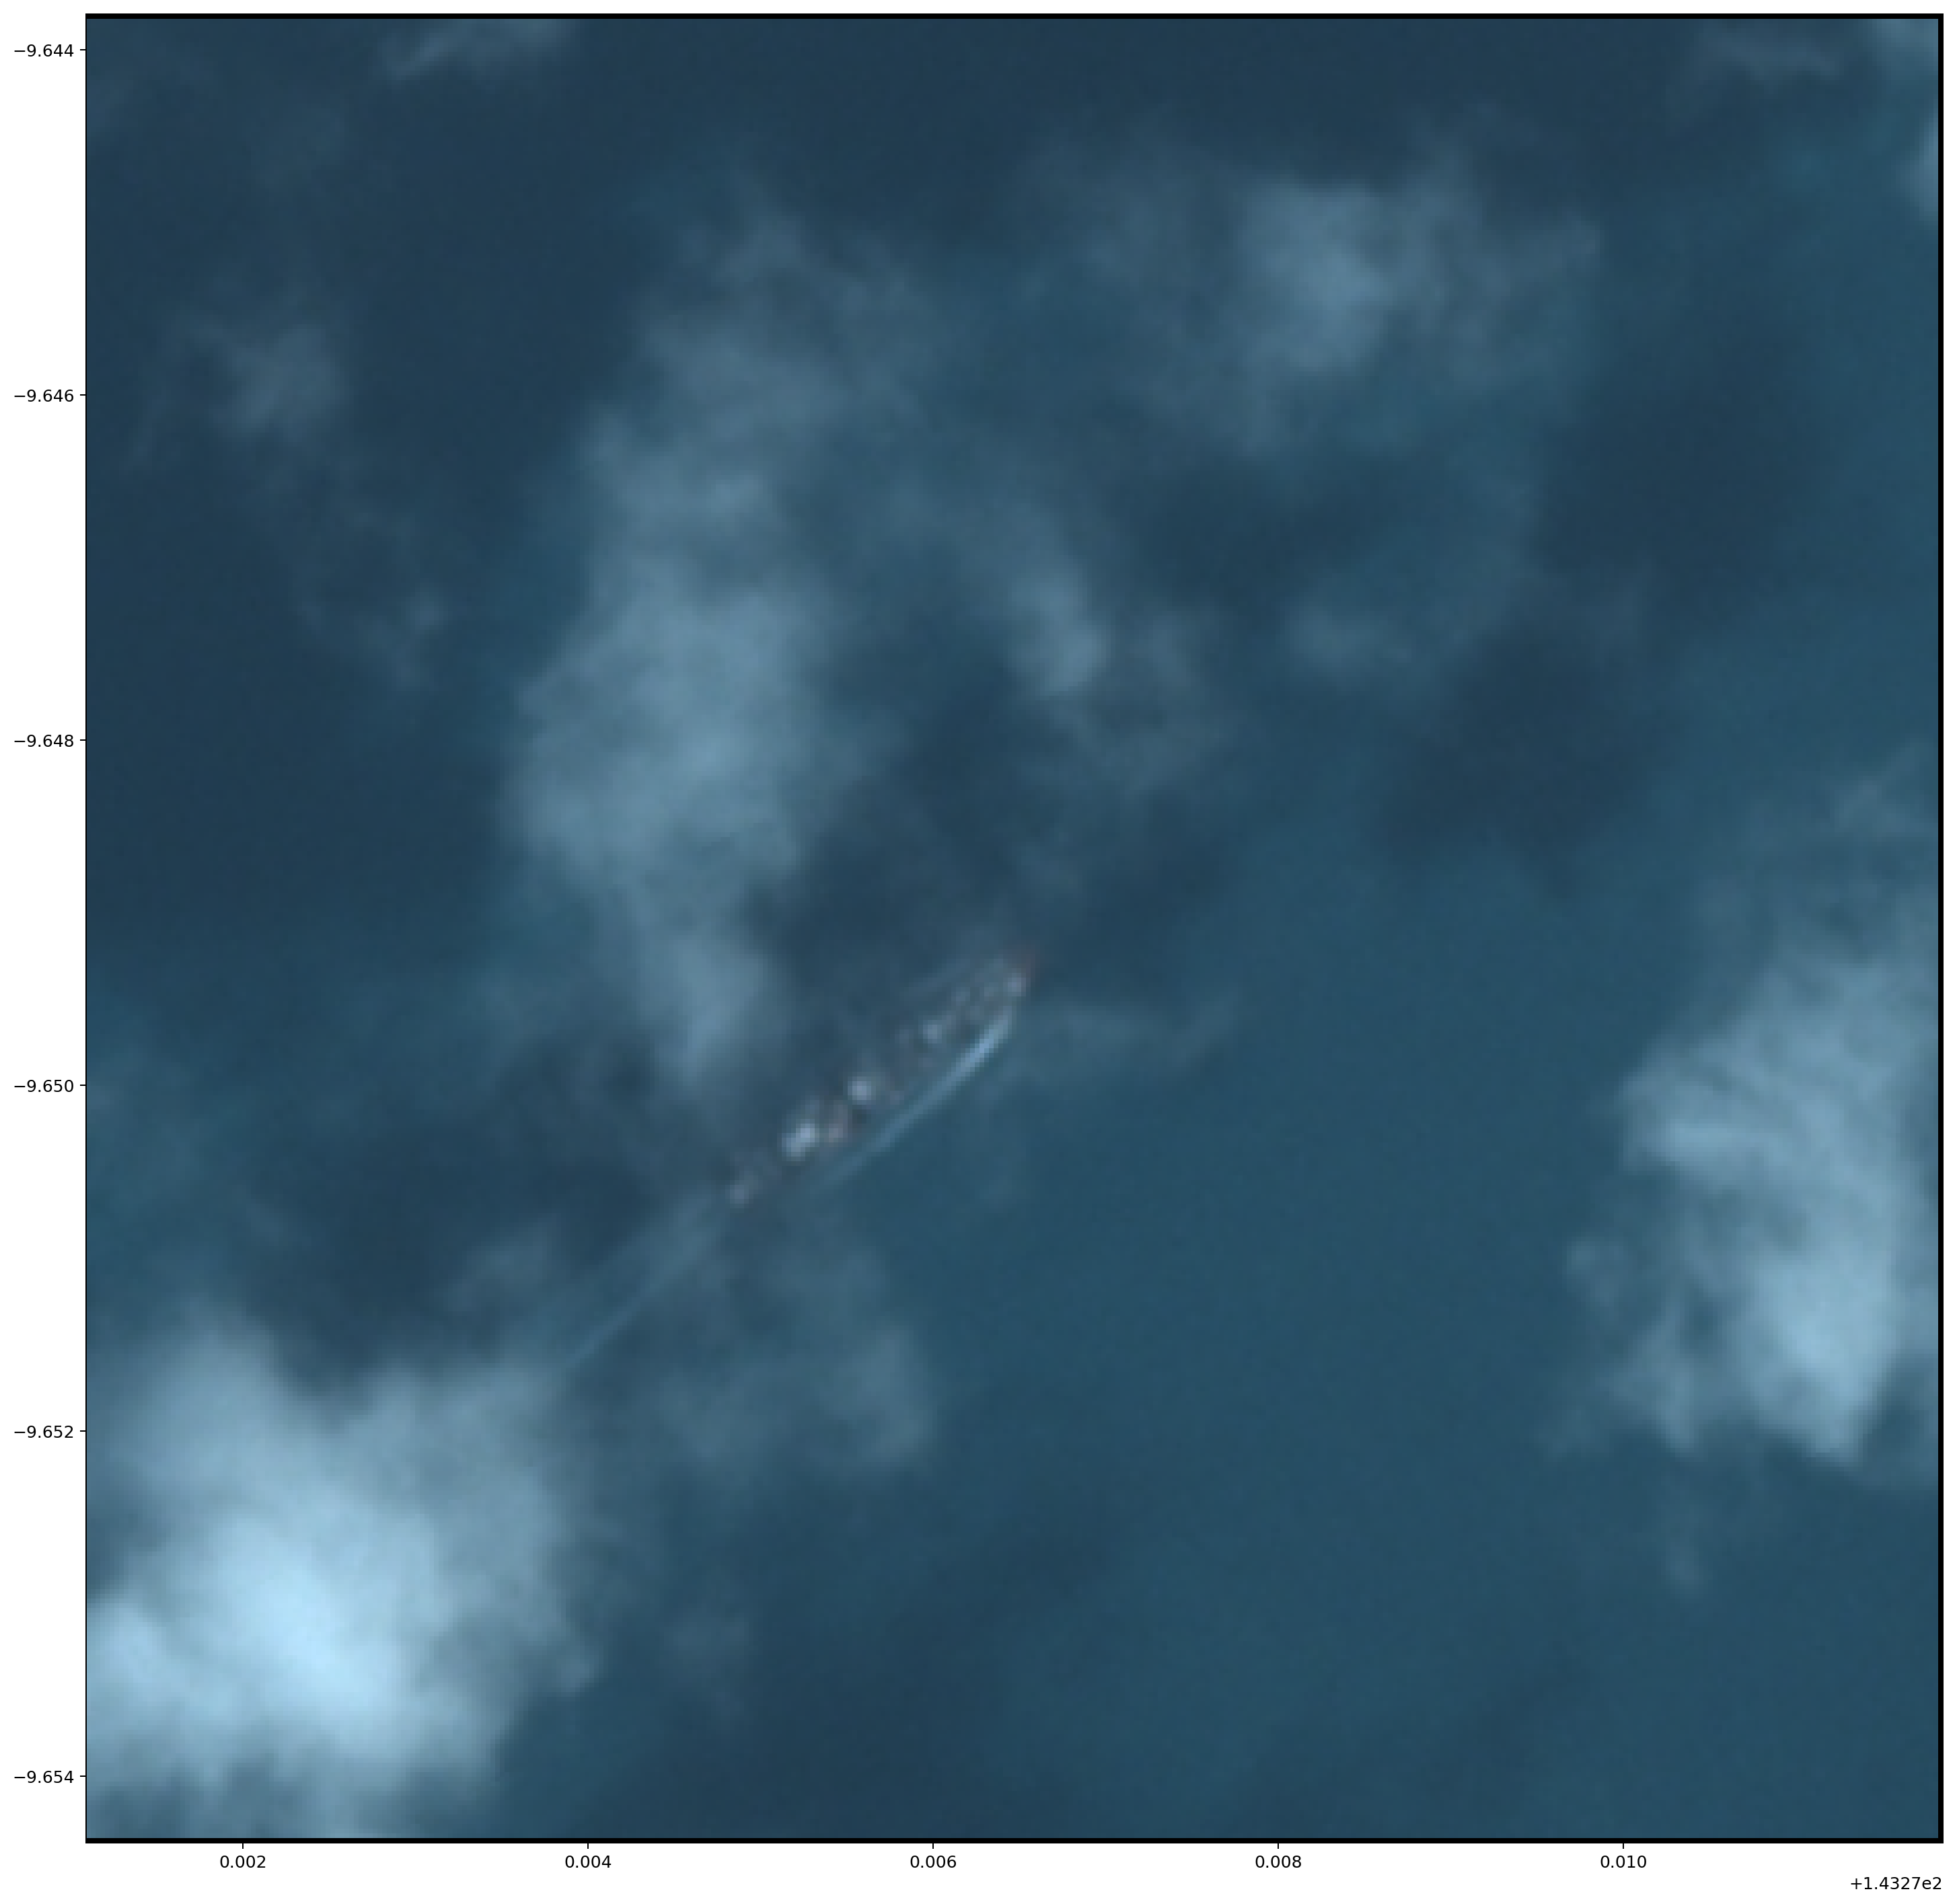

9
crop_20161128_061547_1_0c41.tif


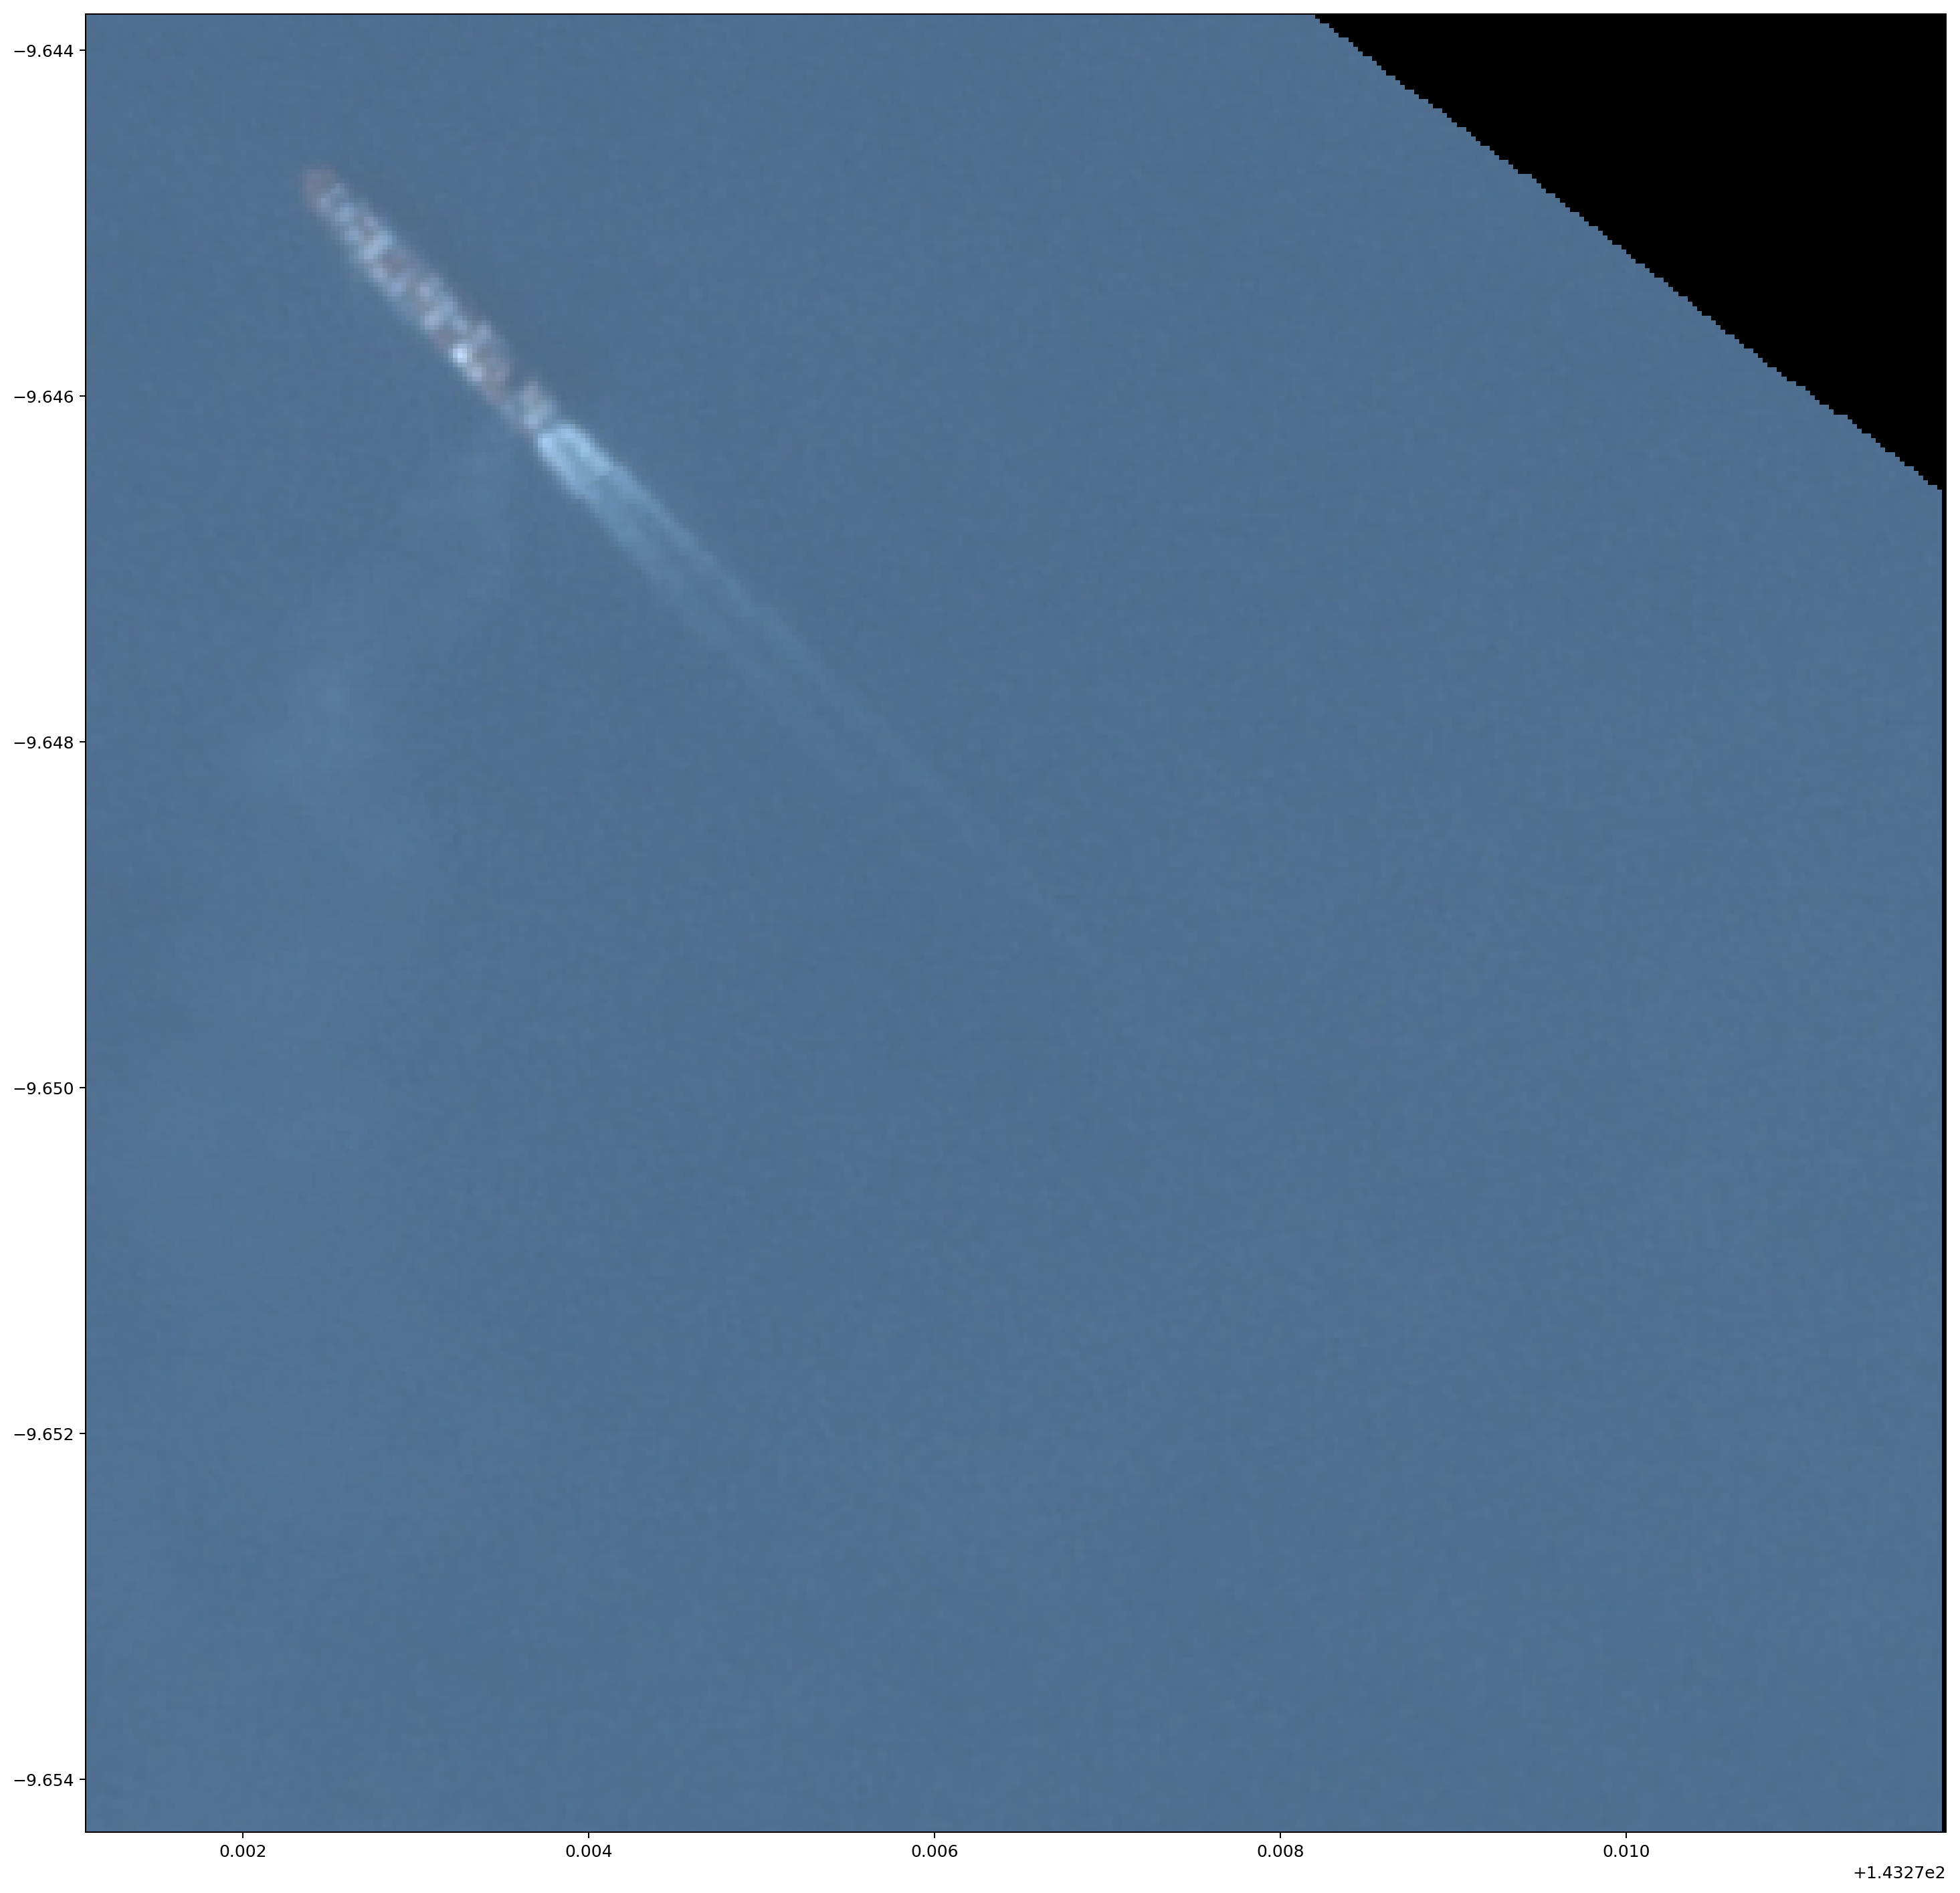

10
crop_20161101_062105_0c42.tif


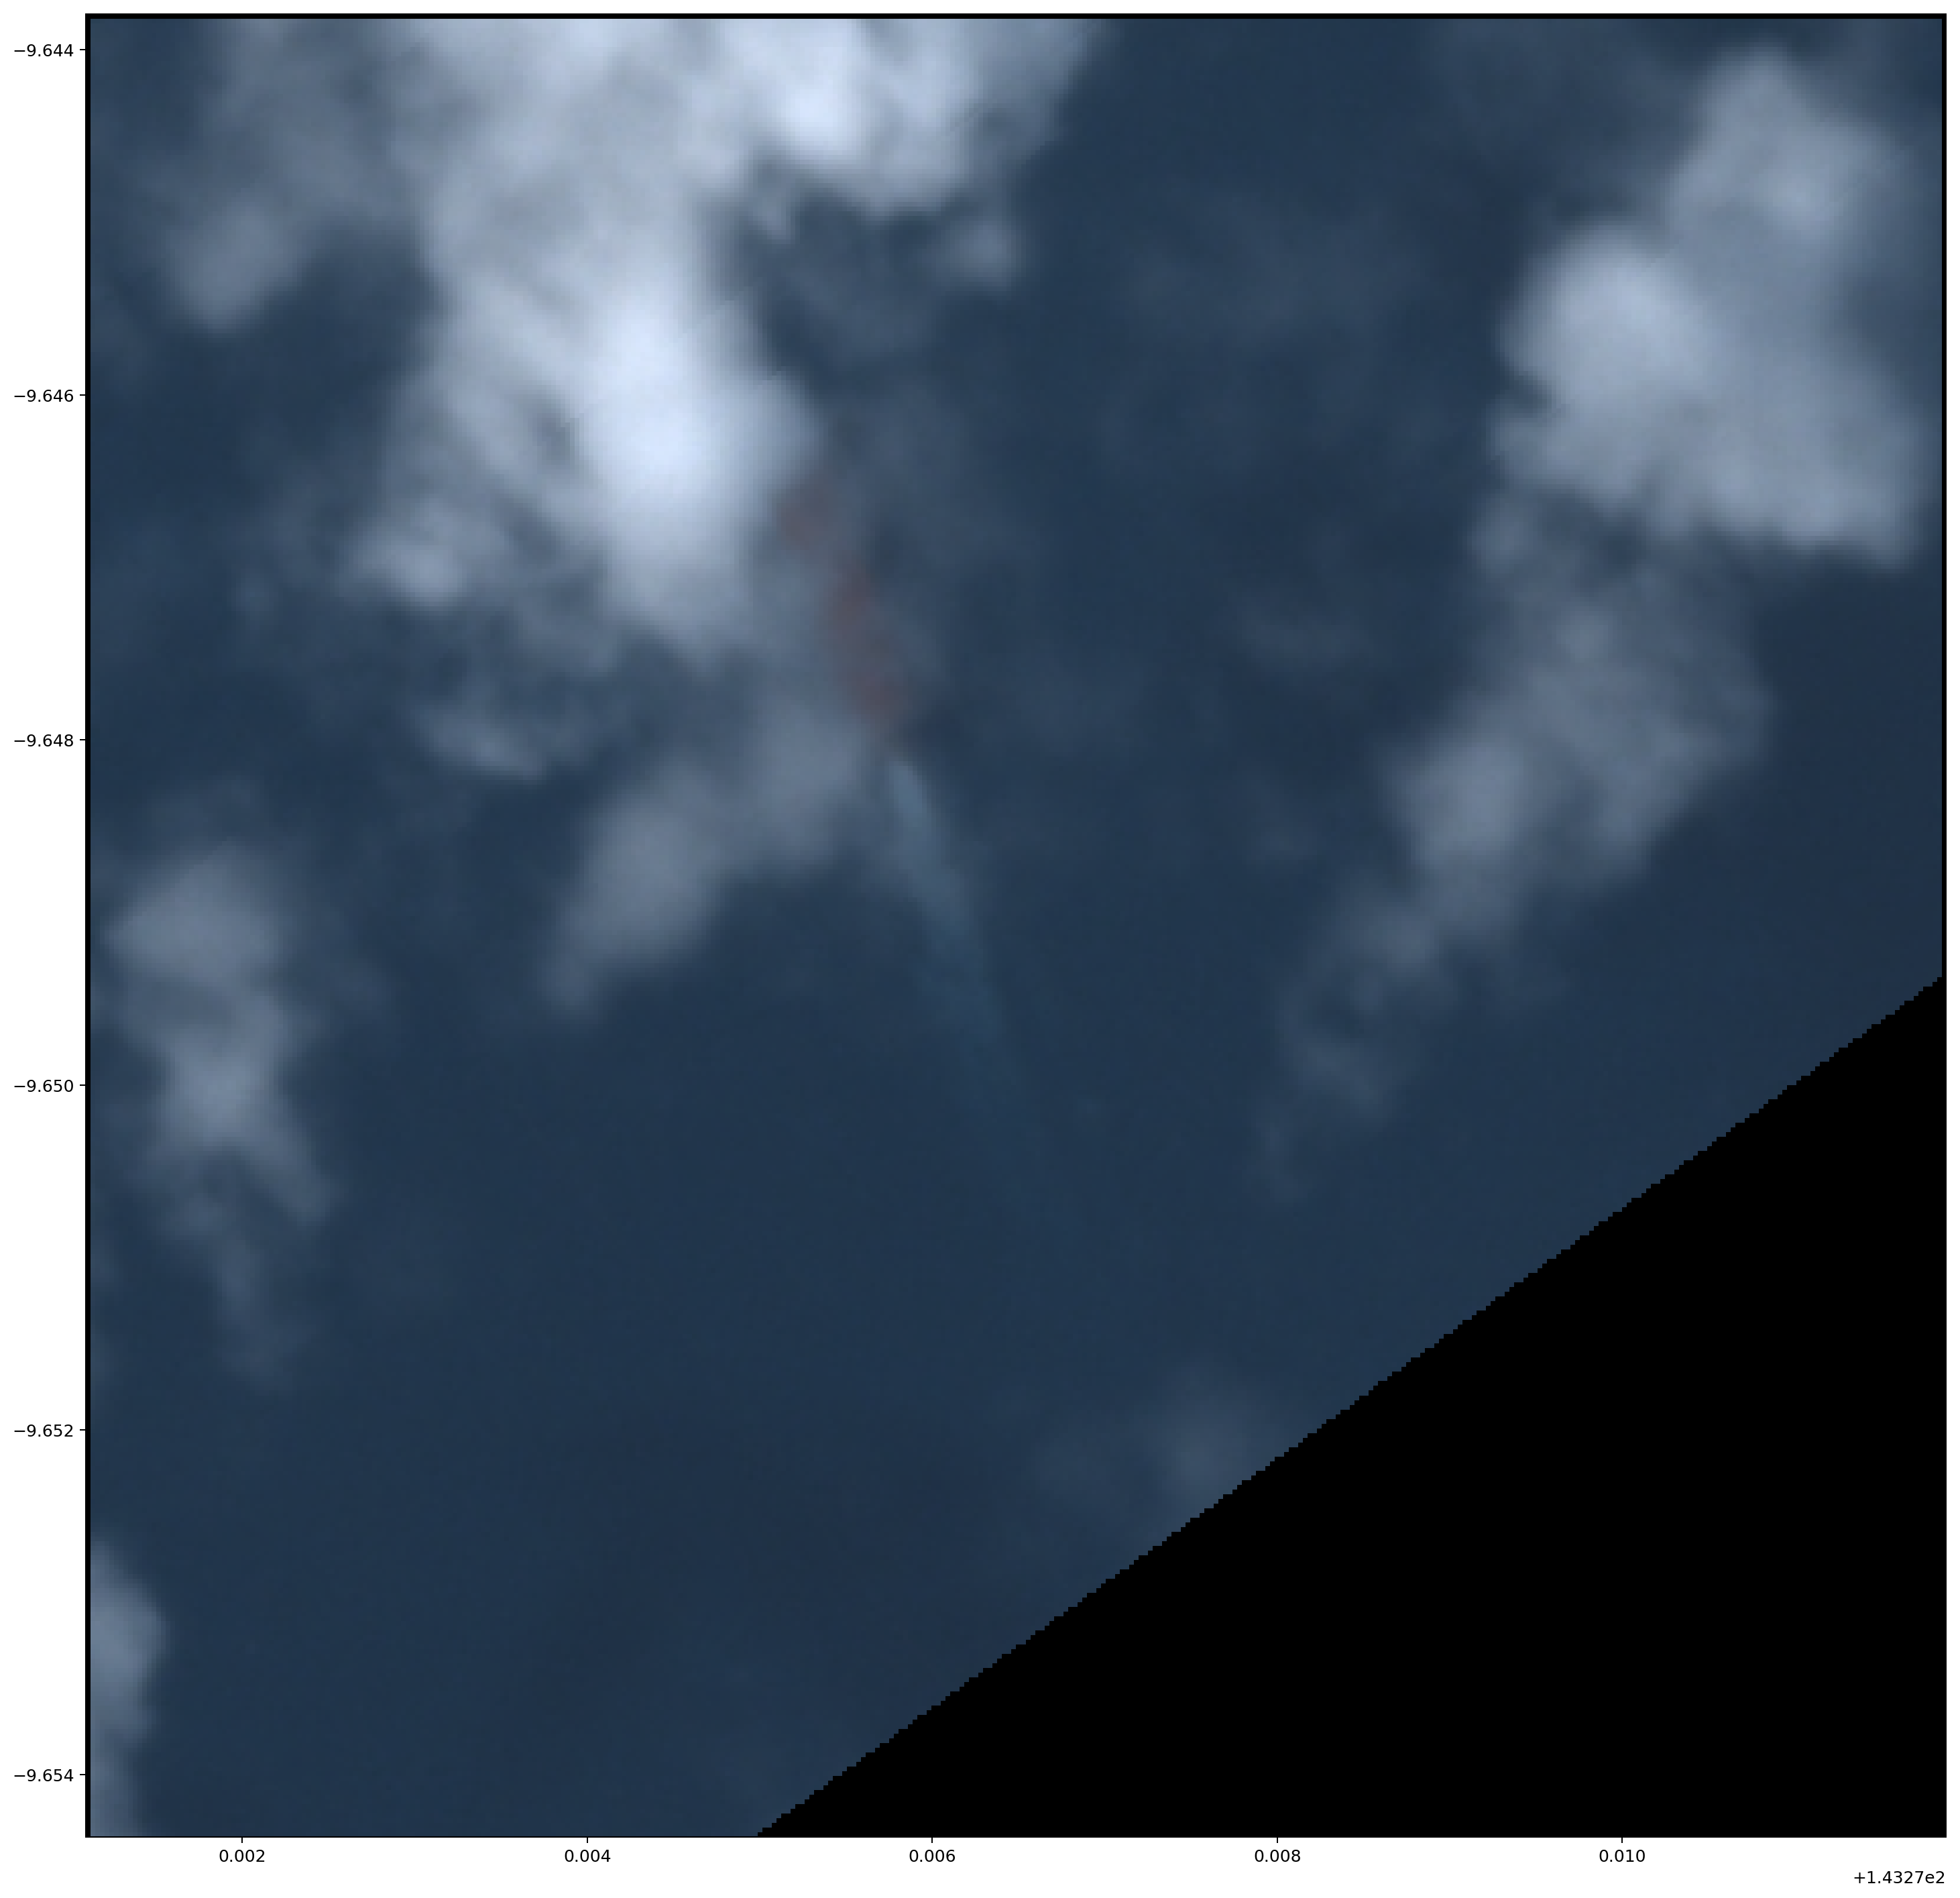

11
crop_20161007_235626_0e2f.tif


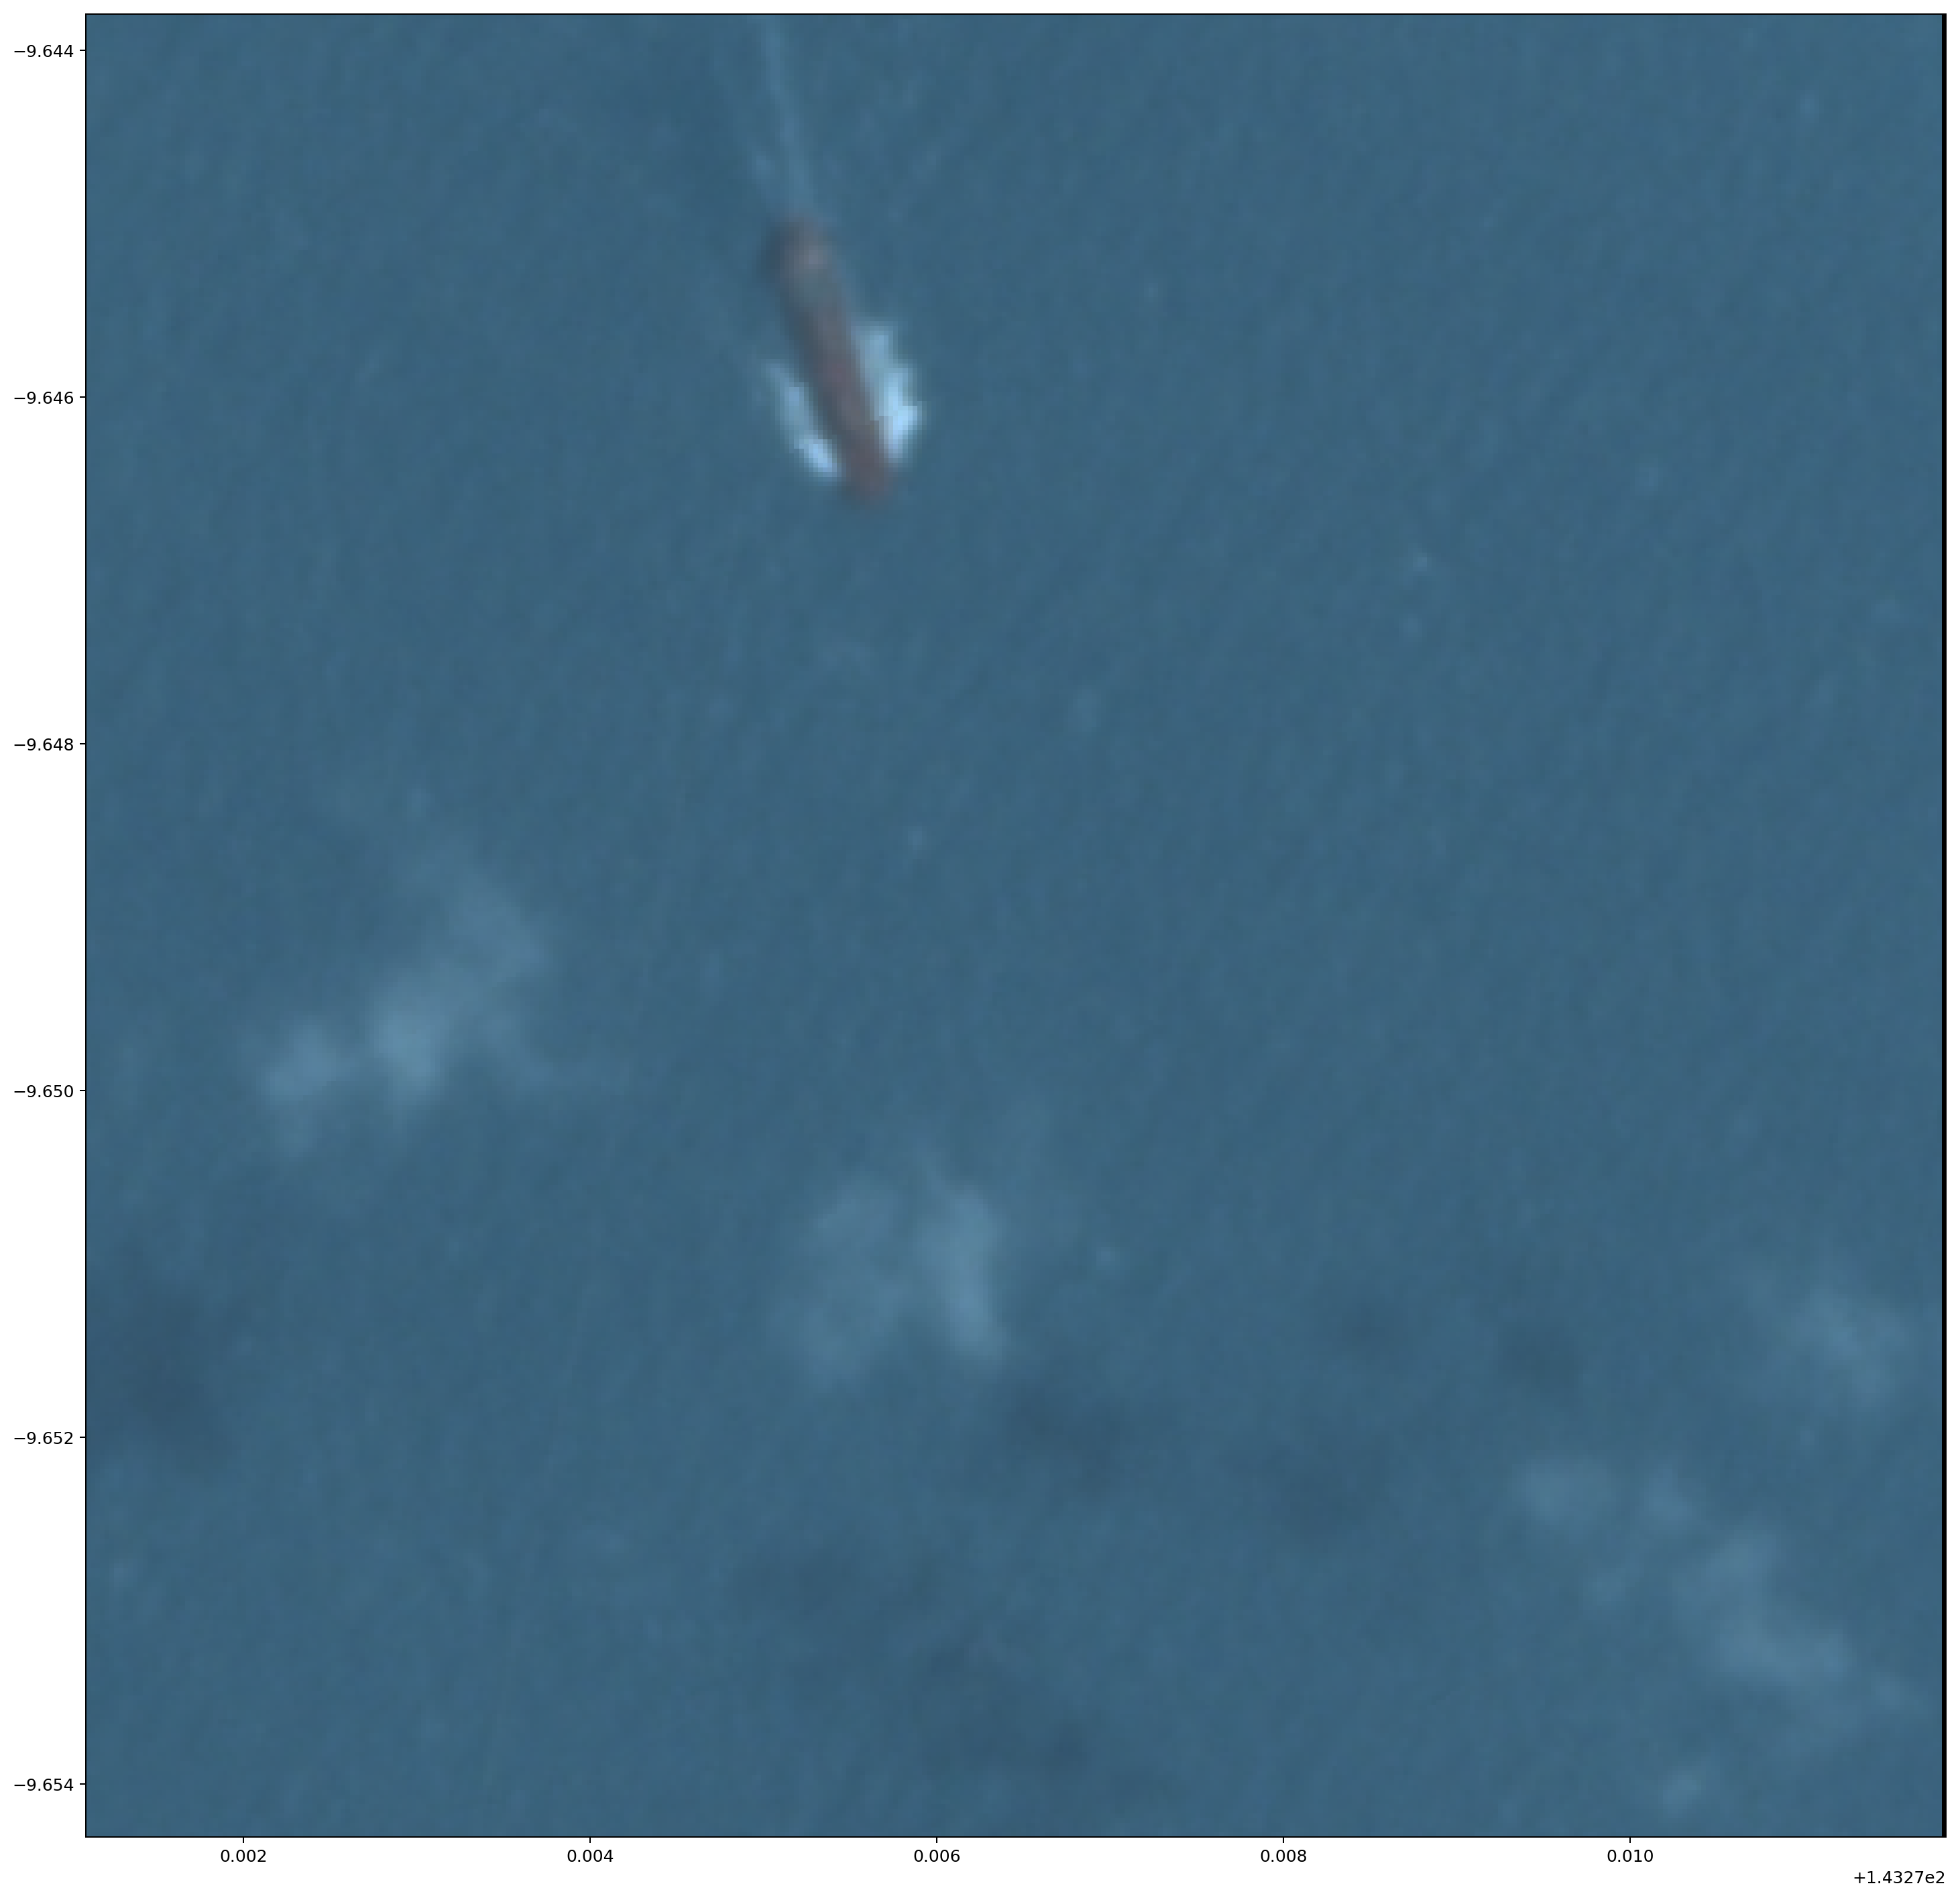

In [130]:
#Plot manually selected images
path = '/mnt/data/shared/planet/imgs_ts/' 
files_planet_proj = [x for x in os.listdir(path) if x.startswith('crop_')]
images_vessels = [0, 3, 12, 18, 19, 20, 21, 23, 26, 28, 31,33]
files_planet_proj_vessels = [files_planet_proj[i] for i in images_vessels]

for e, i in enumerate(files_planet_proj_vessels):
    print(e)
    print(i)
    fig = plt.figure(figsize=(20, 20), dpi=180)
    src_crop = rasterio.open(path + i)
    src_crop_8bit = scale8bit(src_crop.read([3, 2, 1]))
    rasterio.plot.show(src_crop_8bit, transform=src.transform)

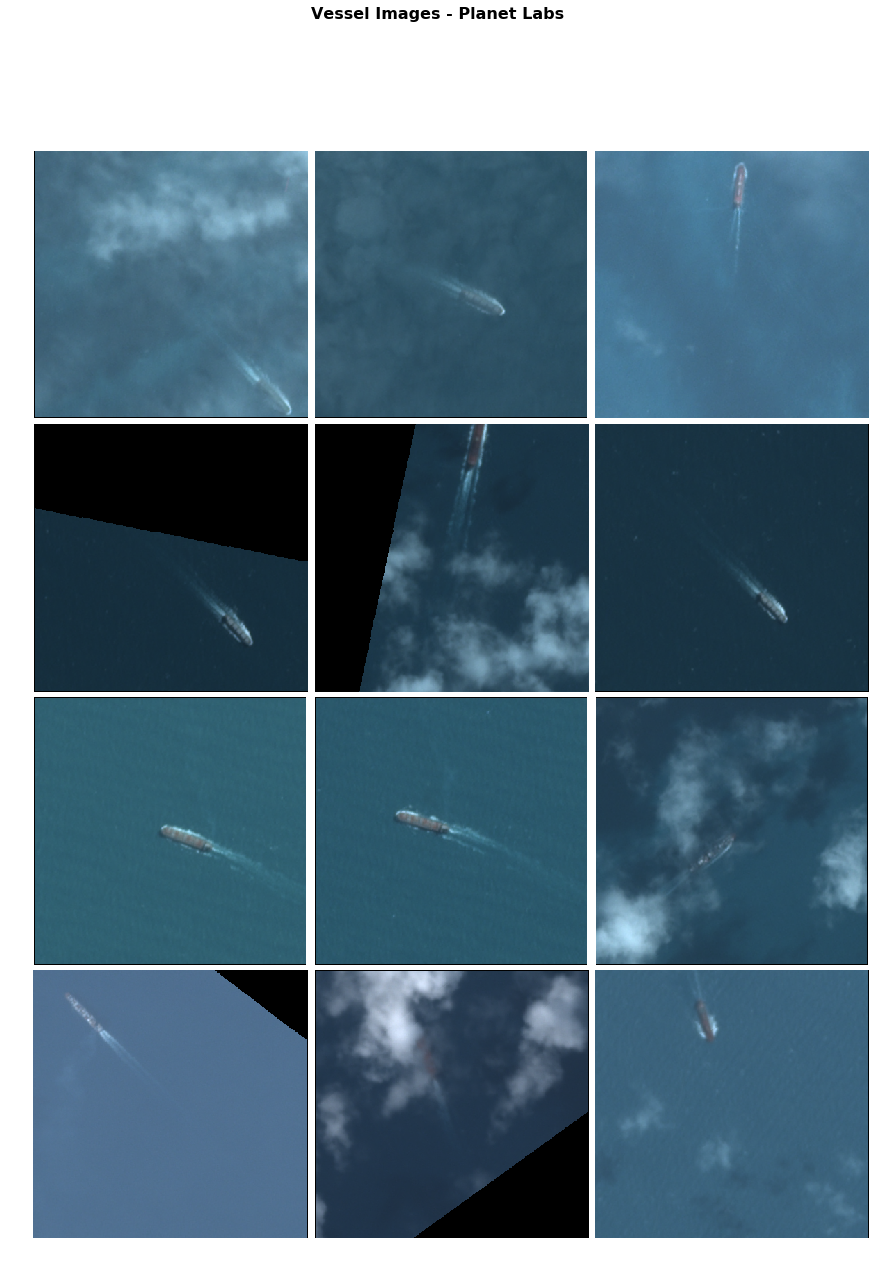

In [210]:
from rasterio.plot import show

fig, axarr = plt.subplots(4,3, figsize=(15,20))
fig.subplots_adjust(wspace=0.02, hspace = 0.02)
fig.suptitle('Vessel Images - Planet Labs', fontsize=16, fontweight='bold')

for i in range(4):
    for j in range(3):
        #Create image index
        if i==0:
            index = i + j
        elif i==1:
            index = (2+i) + j
        elif i==2:
            index = (4+i) + j
        elif i==3:
            index = (6+i) + j
        src_crop = rasterio.open(path + files_planet_proj_vessels[index])
        src_crop_8bit = scale8bit(src_crop.read([3, 2, 1]))
        #Plot data
        plt.sca(axarr[i, j])
        plt.axis("off")
        show(src_crop_8bit, ax=axarr[i, j])
    
#pyplot.show()
plt.savefig('mosaic_planet_torres_strait.png', bbox_inches='tight')